In [1]:
import pandas as pd
df = pd.read_csv('C:/notebook/multiclasstextclassification/all.csv',low_memory=False,encoding = "ISO-8859-1")
df[df.Result == 'Reduce Tariff,Others'].head(20)

,Comment,Result


In [2]:
df.head()

,Comment,Result
0,Ncell La Faltu Paisa Ni Kat X Gharak Partinidi...,Balance Deduction
1,Ali dherai offer dinu paro. Khali paisa matrai...,More offers and services
2,Do fast activity of all action like call recie...,Reduce tariff
3,Kahile kahi ati jaruri huda pani call resive h...,TSC issue
4,1.call rate halka sasto garnu parxa. 2. intern...,Reduce tariff


In [3]:
from io import StringIO
df.columns = [ 'Consumer_complaint_narrative','Product']
df['Product'] = df['Product'].apply(lambda x: str(x).upper())
orgdf = df

In [4]:
df = df[pd.notnull(df['Consumer_complaint_narrative'])]
df = df[df['Product']!='NAN']
df = df[df['Product']!='N/A']

In [5]:
res = df[['Product','Consumer_complaint_narrative']].groupby('Product').count().sort_values('Consumer_complaint_narrative', ascending=False) #.head(14)#.nlargest('Consumer_complaint_narrative',5)
res.index.unique()
df = df[df['Product'].isin(res.index.unique())]

In [6]:
df['category_id'] = df['Product'].factorize()[0]

In [7]:
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

In [8]:
category_to_id = dict(category_id_df.values)

In [9]:
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [10]:
df.groupby('Product').count().sort_values('Consumer_complaint_narrative',ascending=False).head(100)

,Consumer_complaint_narrative,category_id
Product,,
SATISFIED CUSTOMER,15720,15720
REDUCE TARIFF,10934,10934
PRODUCT ENHANCEMENT SUGGESTIONS,9052,9052
IMPROVE NETWORK,7328,7328
EXPAND NETWORK,3735,3735
OTHERS,3055,3055
CONTACT CENTER RELATED,3007,3007
MORE OFFERS AND SERVICES,2630,2630
BALANCE DEDUCTION,2552,2552


In [11]:
category_to_id

{'BALANCE DEDUCTION': 0,
 'MORE OFFERS AND SERVICES': 1,
 'REDUCE TARIFF': 2,
 'TSC ISSUE': 3,
 'IMPROVE NETWORK': 4,
 'PRODUCT ENHANCEMENT SUGGESTIONS': 5,
 'EXPAND NETWORK': 6,
 'CONTACT CENTER RELATED': 7,
 'SATISFIED CUSTOMER': 8,
 'OTHERS': 9,
 'AGENT RELATED': 10,
 'BETTER OFFERS AND SERVICES': 11,
 'RETAIL CHANNEL RELATED': 12,
 'FREE OFFERS AND SERVICES': 13,
 'NCELL CENTER RELATED': 14,
 'DISSATISFIED CUSTOMER': 15}

In [12]:
pd.set_option
('display.max_colwidth', -1)
df[df.Product =='PRODUCT ENHANCEMENT SUGGESTIONS'].head(2)

,Consumer_complaint_narrative,Product,category_id
10,yasko lagi ncell le fast net ani bonous ma mb ...,PRODUCT ENHANCEMENT SUGGESTIONS,5
18,1=Day voice **** kharid garda Bihan 5 to Sujha...,PRODUCT ENHANCEMENT SUGGESTIONS,5


### Imbalanced Classes

<IPython.core.display.Javascript object>


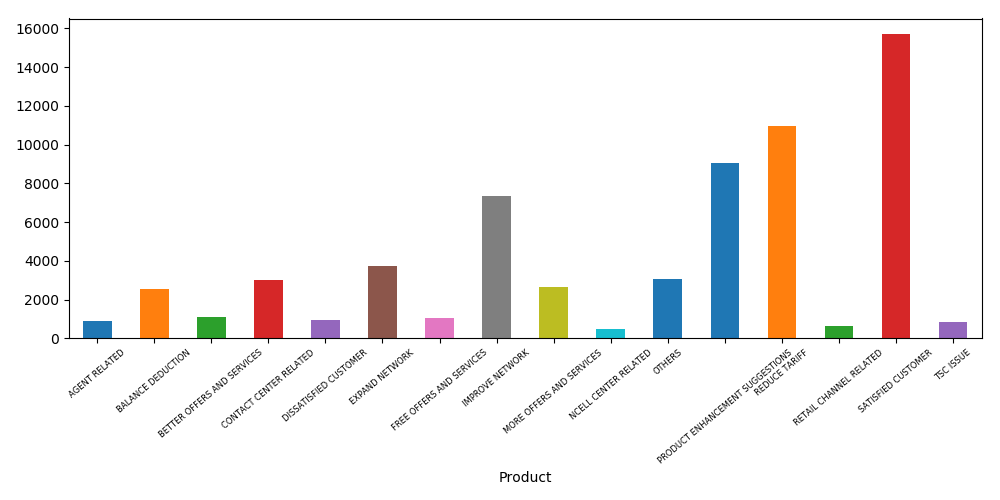

In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure(figsize=(10,5))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.xticks(rotation=40)
plt.rc('xtick',labelsize=6)
plt.tight_layout()
plt.show()

##### Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

###### bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,max_df=.50, norm='l2', encoding='latin-1', ngram_range=(1, 2))

In [87]:
from sklearn.externals import joblib
tfidf_vect_fit = tfidf.fit(df.Consumer_complaint_narrative)

joblib.dump(tfidf_vect_fit, "tfidf.pkl")

features = tfidf_vect_fit.transform(df.Consumer_complaint_narrative).toarray() 


In [67]:
labels = df.category_id
features.shape

(63943, 40437)

In [68]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'AGENT RELATED':
  . Most correlated unigrams:
. bolne
. bolnu
  . Most correlated bigrams:
. bolnu paryo
. be polite
# 'BALANCE DEDUCTION':
  . Most correlated unigrams:
. paisa
. balance
  . Most correlated bigrams:
. mb huda
. main balance
# 'BETTER OFFERS AND SERVICES':
  . Most correlated unigrams:
. ramra
. ramro
  . Most correlated bigrams:
. ramro ramro
. ramro sewa
# 'CONTACT CENTER RELATED':
  . Most correlated unigrams:
. phone
. receive
  . Most correlated bigrams:
. center ma
. call receive
# 'DISSATISFIED CUSTOMER':
  . Most correlated unigrams:
. chor
. chaina
  . Most correlated bigrams:
. tyati santusta
. santusta chaina
# 'EXPAND NETWORK':
  . Most correlated unigrams:
. 3g
. 4g
  . Most correlated bigrams:
. ma 4g
. 4g network
# 'FREE OFFERS AND SERVICES':
  . Most correlated unigrams:
. nisulka
. free
  . Most correlated bigrams:
. call free
. free call
# 'IMPROVE NETWORK':
  . Most correlated unigrams:
. problem
. network
  . Most correlated bigrams:
. network ko

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

joblib.dump(count_vect, "count_vect.pkl")
joblib.dump(tfidf_transformer, "tfidf_transformer.pkl")


clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [70]:
r = 'it should be less cheaper than now ,it help to get ncell n used ncell by every people n it shold be provide international call benifit'
print(clf.predict(count_vect.transform([r])))
df[df['Consumer_complaint_narrative'] == r]

['REDUCE TARIFF']


,Consumer_complaint_narrative,Product,category_id
95342,"it should be less cheaper than now ,it help to...",REDUCE TARIFF,2


In [71]:
print(clf.predict(count_vect.transform([r])))

['REDUCE TARIFF']


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<IPython.core.display.Javascript object>


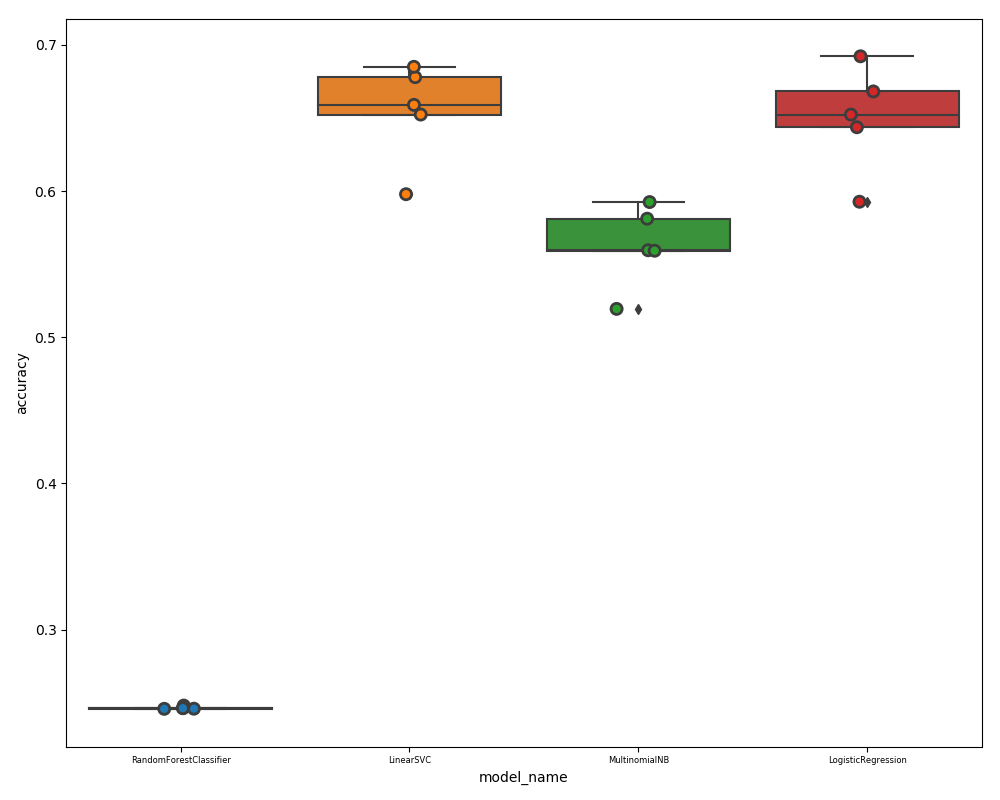

In [73]:
fig = plt.figure(figsize=(10,8))

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.tight_layout()
plt.show()

In [74]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.654431
LogisticRegression        0.649819
MultinomialNB             0.562333
RandomForestClassifier    0.246391
Name: accuracy, dtype: float64

In [75]:
df.head()

,Consumer_complaint_narrative,Product,category_id
0,Ncell La Faltu Paisa Ni Kat X Gharak Partinidi...,BALANCE DEDUCTION,0
1,Ali dherai offer dinu paro. Khali paisa matrai...,MORE OFFERS AND SERVICES,1
2,Do fast activity of all action like call recie...,REDUCE TARIFF,2
3,Kahile kahi ati jaruri huda pani call resive h...,TSC ISSUE,3
4,1.call rate halka sasto garnu parxa. 2. intern...,REDUCE TARIFF,2


In [76]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
linearClf = model.fit(X_train, y_train)
y_pred = linearClf.predict(X_test)
print(y_pred)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)


joblib.dump(count_vect, "count_vect.pkl")
joblib.dump(tfidf_transformer, "tfidf_transformer.pkl")
joblib.dump(linearClf, 'multiclasstextclassification.pkl', compress=9)

[8 8 2 ... 2 7 2]


['tfidf_transformer.pkl']

In [85]:
categoryid = category_id_df.set_index('category_id').to_dict()['Product']

# Save
#dictionary = {'hello':'world'}
np.save('categoryid.npy', categoryid) 


<IPython.core.display.Javascript object>


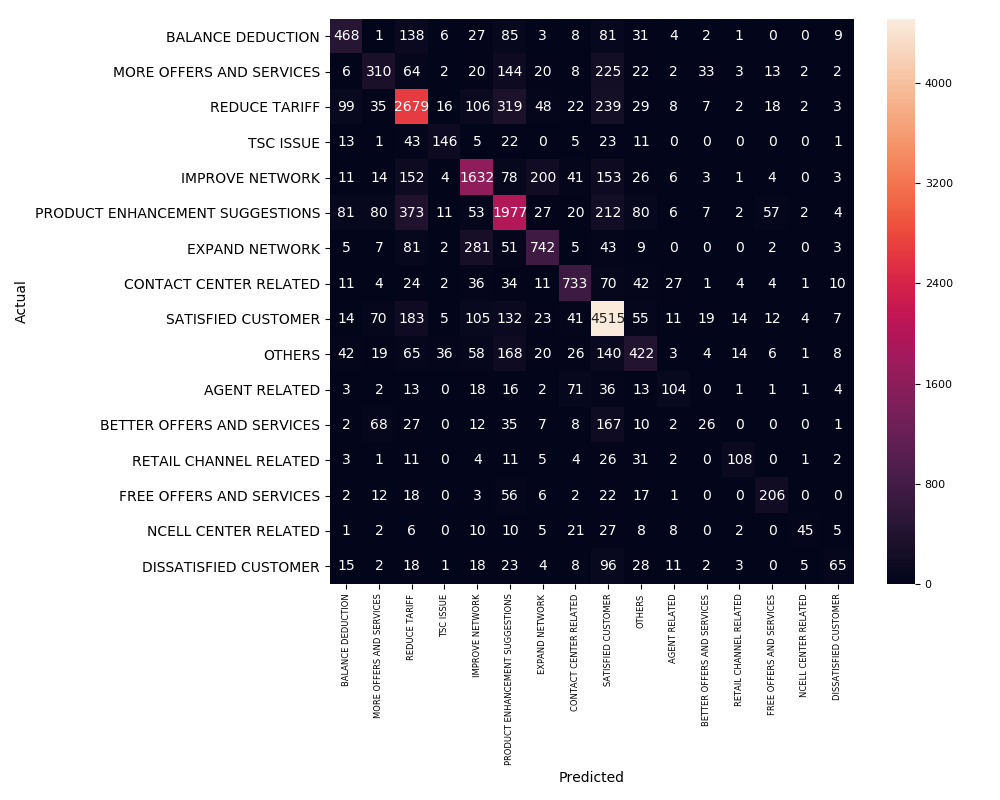

In [78]:
fig, ax = plt.subplots(figsize=(10,8))
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [79]:
from IPython.display import display
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'REDUCE TARIFF' predicted as 'BALANCE DEDUCTION' : 99 examples.


,Product,Consumer_complaint_narrative
93988,REDUCE TARIFF,tapiko ncell la dari poisa katyo tasto hunu vayna
91342,REDUCE TARIFF,mb +net balance pani ekaichoti katchha kina?an...
90263,REDUCE TARIFF,Aru ncell ko sabai sewa ramro lakxa tara faceb...
96924,REDUCE TARIFF,Hajur Jo dobber paisa back chani tesma sabaila...
95898,REDUCE TARIFF,ncell le dheraii paisa katxa ...???? ae **** s...
94557,REDUCE TARIFF,Main balance bata bet chalaudaa dherai paisaa ...
96632,REDUCE TARIFF,Thank you malai k lagxa vane ncell le sewa sub...
90214,REDUCE TARIFF,Facebook chalauda mb xito xito katxa teslai ka...
89636,REDUCE TARIFF,Ushori thakai x bt yesma mb mena blc dheri kat...
97111,REDUCE TARIFF,Subidha matra vanara vayana aie paxe paisa lut...



'TSC ISSUE' predicted as 'BALANCE DEDUCTION' : 13 examples.


,Product,Consumer_complaint_narrative
113487,TSC ISSUE,Ncell ma text badi katdo rahe x achel so
3,TSC ISSUE,Kahile kahi ati jaruri huda pani call resive h...
113806,TSC ISSUE,Ncell le dhelo rpl garx hamro **** sakda ani p...
795,TSC ISSUE,Vat Ali ghatai dinu vaye hunthyo? Kunai kunai ...
113380,TSC ISSUE,Euta prashna hajurharulai pani sodna chahanchh...
113743,TSC ISSUE,Yo jun system xo ahileko taxc katne tyo system...
113377,TSC ISSUE,Rs. 9 dekhyerw Mb tanda Rs . 11 katxa yeslai 1...
113401,TSC ISSUE,ma ncell ko subidhama 1 kurama santustha xain ...
791,TSC ISSUE,xen xen ma blnc katne ani Mb huda hudai ni bin...
113870,TSC ISSUE,Ncell bata mb convert garda kaar xai kina pahi...



'IMPROVE NETWORK' predicted as 'BALANCE DEDUCTION' : 11 examples.


,Product,Consumer_complaint_narrative
19692,IMPROVE NETWORK,Mero Data on grnu pittikai Data fast katira x ...
20314,IMPROVE NETWORK,Ncell data lo chha Data use gardai MB ko sath ...
18234,IMPROVE NETWORK,Sala chor company phone na lagne paisa matra k...
664,IMPROVE NETWORK,Yati bela ncell ko calling subhidha pani clear...
22496,IMPROVE NETWORK,Nepalko vougolik biktta KO karn ktipy thau che...
662,IMPROVE NETWORK,net fast hunu paro tetikai balance cut hunxa y...
661,IMPROVE NETWORK,Net slo chalxa .na cahine blc katxa ani pakej ...
684,IMPROVE NETWORK,Ncell ka gunastariya banaunaka lagi 1 network ...
17678,IMPROVE NETWORK,Mero paila ko sim ma tower nai aauna xodyo .. ...
3022,IMPROVE NETWORK,ncell past ma dherai ramroo thiyo.. but aile a...



'PRODUCT ENHANCEMENT SUGGESTIONS' predicted as 'BALANCE DEDUCTION' : 81 examples.


,Product,Consumer_complaint_narrative
82798,PRODUCT ENHANCEMENT SUGGESTIONS,Balance cut off vayo vane reson tetinai bela d...
81184,PRODUCT ENHANCEMENT SUGGESTIONS,6 rsko 24 mb malai man parena kina ki tyo mb 1...
84752,PRODUCT ENHANCEMENT SUGGESTIONS,Mb **** huda pni blance catcha npl to nepal ph...
84966,PRODUCT ENHANCEMENT SUGGESTIONS,1. Net package leko lie MB huda hudai blnc kat...
82857,PRODUCT ENHANCEMENT SUGGESTIONS,Grahak haru le jati patak pani backton sunnata...
2213,PRODUCT ENHANCEMENT SUGGESTIONS,Jastai mero sim pahila paisa thiyo tyo paisa k...
82871,PRODUCT ENHANCEMENT SUGGESTIONS,Net chalauda mb sake poxi auto of huno paryo n...
82550,PRODUCT ENHANCEMENT SUGGESTIONS,U have to inform all the notification Before E...
86322,PRODUCT ENHANCEMENT SUGGESTIONS,HAMILE NCELL PARYOG GARDA POISA K KARN LE K GA...
79455,PRODUCT ENHANCEMENT SUGGESTIONS,Hajur mero arko mobile ma mb tana ku66u teha d...



'CONTACT CENTER RELATED' predicted as 'BALANCE DEDUCTION' : 11 examples.


,Product,Consumer_complaint_narrative
11661,CONTACT CENTER RELATED,NEW **** KO MANAGE HOS COSTOMAR CAER SAGA DIRE...
10844,CONTACT CENTER RELATED,bina karan ksaiko pni balance nkatos ani 9005 ...
9955,CONTACT CENTER RELATED,Tyasto kehi pani xaina euta problem blance sun...
11765,CONTACT CENTER RELATED,Mobile ko balance kteko kteko garxa call cente...
10687,CONTACT CENTER RELATED,grahak partinidhi saga kura garda patak patak ...
9492,CONTACT CENTER RELATED,sewa aanusar ko balance ma katautii garnu parx...
9303,CONTACT CENTER RELATED,Ncell bata kura garda dhearai paesa kat6 ani m...
11272,CONTACT CENTER RELATED,New offer lunch garda jankari sure ma nai tas ...
9966,CONTACT CENTER RELATED,Sab vandaa pahila Jo yo Tapai haru ko careless...
625,CONTACT CENTER RELATED,Call center help garana basya Rey saala ekxin ...



'SATISFIED CUSTOMER' predicted as 'BALANCE DEDUCTION' : 14 examples.


,Product,Consumer_complaint_narrative
111838,SATISFIED CUSTOMER,Ncell paryog garnya paryog karta haru vagya sa...
112795,SATISFIED CUSTOMER,Ahile Samma Vane Anusar Nai Money Kati Raxa Sa...
781,SATISFIED CUSTOMER,hajur haru ko ncell ko ko swa subidha haru nik...
100932,SATISFIED CUSTOMER,i think all well u cut more money thats may be...
101138,SATISFIED CUSTOMER,Ncell mA dherOi facility harU xaN bUT ncell mA...
113321,SATISFIED CUSTOMER,anaawasyak sms diyera ncell paisa kateko thikk...
97888,SATISFIED CUSTOMER,toit poisa pauxu vnerw **** leko tw last ma tw...
106042,SATISFIED CUSTOMER,Ncell ko sewa le thorai paisa ma dherai talk t...
107011,SATISFIED CUSTOMER,Jun price tokxa teti nai hamro blc bat katxa t...
108018,SATISFIED CUSTOMER,Ncell ek dam ramro SIM xa Nepal ma Ncell 1 sim...



'OTHERS' predicted as 'BALANCE DEDUCTION' : 42 examples.


,Product,Consumer_complaint_narrative
78025,OTHERS,4G service Activate gardani kin chaldain n 4G ...
76858,OTHERS,"Yo sim-cardma balance thiyana,kina ho?"
76782,OTHERS,Ani maile transfer gareko balance chai k hunxanii
79256,OTHERS,tapai haru le paisa kamauna badi dhyan dinu bh...
584,OTHERS,Ncell has deducted money from my balance and a...
77757,OTHERS,Kunai pani sewa aafau sucharu vaihalz ncell si...
77724,OTHERS,Sewaharu aafai suchu hunx t..kin. ? Hami lai t...
77495,OTHERS,Maile 1ooo SMS ko **** Lida Paisa kateo Tara *...
77731,OTHERS,dhnyawad kun belaa costumercare maa cl garda c...
76914,OTHERS,Online hudha game news vaner k k bijyapan xau ...



'DISSATISFIED CUSTOMER' predicted as 'BALANCE DEDUCTION' : 15 examples.


,Product,Consumer_complaint_narrative
12611,DISSATISFIED CUSTOMER,Ma matra kaatyo bha ko paisa pani sakto bekar ...
12296,DISSATISFIED CUSTOMER,I had claim Ncell for my loss of balance n sti...
12602,DISSATISFIED CUSTOMER,Ncell sucks our money
11901,DISSATISFIED CUSTOMER,Maro tah konai fayeda bhayen
12083,DISSATISFIED CUSTOMER,Ncell vane ekdam thak ho paisa lutn4
640,DISSATISFIED CUSTOMER,I really don't like Ncell system because it un...
12620,DISSATISFIED CUSTOMER,Mero mobilema ghari ghari si nachalnuko reason...
12448,DISSATISFIED CUSTOMER,kaile kai aafai paisa cut hunxa vanxan sathi h...
12503,DISSATISFIED CUSTOMER,Aajai pani ncell leee customer lai satisfy gar...
12167,DISSATISFIED CUSTOMER,Umm yo purano sim jhikda pni paisa tirna parne...



'REDUCE TARIFF' predicted as 'MORE OFFERS AND SERVICES' : 35 examples.


,Product,Consumer_complaint_narrative
92724,REDUCE TARIFF,Subidha ramro banauna hajur haru grakh haru la...
1595,REDUCE TARIFF,Ncell auta best service ****. Yaslae ajhae ram...
93276,REDUCE TARIFF,Moh tpai lai ncell ko subidha lai ajha ramro b...
92381,REDUCE TARIFF,It's too much taxes which is cheating people.b...
93775,REDUCE TARIFF,Sewa subiharu sastodarma dinuhola . Dhanyadad
3405,REDUCE TARIFF,jo tapaiharule monthlee v **** subida dinu bha...
4838,REDUCE TARIFF,Aafu lai pareko samasya ncell ka bivinna sewa ...
88791,REDUCE TARIFF,Tapai harla hami jasto lomo samaya samma kura ...
93436,REDUCE TARIFF,Aja Sa Sewa Subida Ma Kunai Complane Xain But ...
90840,REDUCE TARIFF,free twitter jasto offer haru kayem rahos gprs...



'IMPROVE NETWORK' predicted as 'MORE OFFERS AND SERVICES' : 14 examples.


,Product,Consumer_complaint_narrative
20518,IMPROVE NETWORK,Ncell pareoga kartako lagi tapai harule jaha d...
2533,IMPROVE NETWORK,"Ncell Nepal vari ramro network bistar garos, b..."
23090,IMPROVE NETWORK,network sabai place ma ramro sanga clear cha k...
20495,IMPROVE NETWORK,Ncell ko tower thap garera grahak harulai ajha...
20695,IMPROVE NETWORK,kaile kaile naya sim ma tower na aaunu ko kara...
18203,IMPROVE NETWORK,Mero sujhav> customer le phone garda BG navaya...
23215,IMPROVE NETWORK,ncel thap estarea banauna maro cahana
18048,IMPROVE NETWORK,Ncell ma call garna ni ramro cha ta net ko lag...
2174,IMPROVE NETWORK,Sabai tira ramro networ dinu....ani ajhai ramr...
21667,IMPROVE NETWORK,OK ncell LA ajha badi sewa ani net supeer chal...



'PRODUCT ENHANCEMENT SUGGESTIONS' predicted as 'MORE OFFERS AND SERVICES' : 80 examples.


,Product,Consumer_complaint_narrative
86844,PRODUCT ENHANCEMENT SUGGESTIONS,"Network ko capacity ajhai ramro banaunu paryo,..."
82664,PRODUCT ENHANCEMENT SUGGESTIONS,Unlimited data and call masik sulk ma ramro hu...
86836,PRODUCT ENHANCEMENT SUGGESTIONS,Ramro ramro bonus pathauny
83002,PRODUCT ENHANCEMENT SUGGESTIONS,malai lagxa bonus haru ta dherai dinuvayeko xa...
84943,PRODUCT ENHANCEMENT SUGGESTIONS,If any thing first should send massge than giv...
85837,PRODUCT ENHANCEMENT SUGGESTIONS,voice **** for three month with buy 1 get 1
83118,PRODUCT ENHANCEMENT SUGGESTIONS,Offer Dinu Talktime Ko
87615,PRODUCT ENHANCEMENT SUGGESTIONS,Increase phosphate facilities.
2548,PRODUCT ENHANCEMENT SUGGESTIONS,(1) Kaile kaii yasho ncell baata quiz contains...
83594,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell ka sewq subidhaharu ramro chha grahakpra...



'SATISFIED CUSTOMER' predicted as 'MORE OFFERS AND SERVICES' : 70 examples.


,Product,Consumer_complaint_narrative
101423,SATISFIED CUSTOMER,Offer haru paucha
110715,SATISFIED CUSTOMER,yastai yastai bibhinna kisimka subidhaharu gra...
112317,SATISFIED CUSTOMER,Hami Lai Ncell le thuprai offer haru diyeko x....
107443,SATISFIED CUSTOMER,Suggestion: 1 ncell le dharai subida haru diya...
107961,SATISFIED CUSTOMER,Agami dinharu ma pni yastaii thap subida haru ...
108277,SATISFIED CUSTOMER,Kunai samasya xina tara time time ma new new e...
112701,SATISFIED CUSTOMER,NCELL HAREK PATAK SAMAYE SAMAYE MA BIVINNA PRA...
110779,SATISFIED CUSTOMER,Ncell ko paila haru lamo hudai jaun hamilai pa...
109068,SATISFIED CUSTOMER,Sabai kura tik xa.....yesarinai sath dinu hola...
110754,SATISFIED CUSTOMER,Ajha ramro banauna k bhanam sabai subidha dira...



'OTHERS' predicted as 'MORE OFFERS AND SERVICES' : 19 examples.


,Product,Consumer_complaint_narrative
78183,OTHERS,Ajai dherai ramro baunaka lagi samsara pauna s...
78989,OTHERS,"To Encourage People Use Ncell, There Should Be..."
76625,OTHERS,Ncel bat paun sakne thap subida haru kehi xan ...
78803,OTHERS,Naya offer xa yo number ma
76525,OTHERS,NCELL KO SABAE SEWA HARU SUCHARU GARI DIN BINA...
78663,OTHERS,Give bonus when recharge 100 rupees
79135,OTHERS,first of all student lai xuttai sim card and n...
78341,OTHERS,Bonus didai garnu prachha
78083,OTHERS,Aana students haruu ko lagii kunii ramro offer...
76869,OTHERS,Ani pahile ta100 ko richarg garda bonush dinth...



'BETTER OFFERS AND SERVICES' predicted as 'MORE OFFERS AND SERVICES' : 68 examples.


,Product,Consumer_complaint_narrative
8763,BETTER OFFERS AND SERVICES,Naya vanda naya subeda layawenu paryo jaslaya ...
8879,BETTER OFFERS AND SERVICES,Ncell le ajai ramro service ko uplapdha garidi...
8190,BETTER OFFERS AND SERVICES,Sewagrahilai Ajha derai sewa ra subidha pradan...
8584,BETTER OFFERS AND SERVICES,aahiliyaaa samko sabaee thikaee xaaa aajaa tha...
8612,BETTER OFFERS AND SERVICES,jasto sewa ncell le dinu vako x ahile testai s...
8322,BETTER OFFERS AND SERVICES,Something new...things should be improved
8110,BETTER OFFERS AND SERVICES,Mero bichar ma nepalka anya namber ra Antarati...
8649,BETTER OFFERS AND SERVICES,Ncell Ko sewa subidha lai ajha ramro banaauna ...
8877,BETTER OFFERS AND SERVICES,ajoi ramra sewa dinu ani nirantta poni hos
8821,BETTER OFFERS AND SERVICES,A ramro gardae januhos nya naya ncell sistam s...



'FREE OFFERS AND SERVICES' predicted as 'MORE OFFERS AND SERVICES' : 12 examples.


,Product,Consumer_complaint_narrative
16504,FREE OFFERS AND SERVICES,Ajai pani dharae subida haru lena paiyos freca...
16270,FREE OFFERS AND SERVICES,Free net hunuparchha jastai ncell app jastai a...
16786,FREE OFFERS AND SERVICES,Ajha freecall haru didai garnu
16599,FREE OFFERS AND SERVICES,Ncell lai bivinna thau. Ma parchar grne aja ya...
16774,FREE OFFERS AND SERVICES,Ncell prati ko mero sujhaav yo xa ki pratek ha...
16498,FREE OFFERS AND SERVICES,Ncl le monsoon offer ta dinu vayo ramro lagyo ...
16580,FREE OFFERS AND SERVICES,Ajhai naya sewaharu lyaunu paryo ani sabailai ...
16569,FREE OFFERS AND SERVICES,bela belama free mb items haru grahak samu pra...
16060,FREE OFFERS AND SERVICES,100 wa 100 Bhanda badhi recharge garne haru la...
15957,FREE OFFERS AND SERVICES,You have to make all free of 4G service and ma...



'BALANCE DEDUCTION' predicted as 'REDUCE TARIFF' : 138 examples.


,Product,Consumer_complaint_narrative
6100,BALANCE DEDUCTION,aru bhandapani internet chalauda aru sim bhand...
5836,BALANCE DEDUCTION,.paisa khani kam gara xa
7814,BALANCE DEDUCTION,Kehi nagarikanai balence rakam kharch jasto sa...
6484,BALANCE DEDUCTION,Data bata net chalauda feri data sakeni betika...
8036,BALANCE DEDUCTION,Ma aam janta hu. mashubida haru ramro lagxa te...
7971,BALANCE DEDUCTION,Unusual balance reduction during calls mobile ...
7933,BALANCE DEDUCTION,aru khaasai ke ta xena tara balnce badi kaatx ...
7495,BALANCE DEDUCTION,Internet chalaer exit gare turunt blanch check...
1643,BALANCE DEDUCTION,Fb chalauda Kura garda sim ko net nae fast hid...
8041,BALANCE DEDUCTION,Ncell to nell ma call garda 99 paisa per min h...



'MORE OFFERS AND SERVICES' predicted as 'REDUCE TARIFF' : 64 examples.


,Product,Consumer_complaint_narrative
24291,MORE OFFERS AND SERVICES,Ncell ko sewa lai aja dharaii afar leyay ra aw...
3032,MORE OFFERS AND SERVICES,Adi tapaiharule ajha thuprai sebaharu pradan g...
24504,MORE OFFERS AND SERVICES,Ncell le grahak lai ajha subidha diuna taki. G...
25169,MORE OFFERS AND SERVICES,net ko lagii ajhaa dherai vanda dheraii facili...
25695,MORE OFFERS AND SERVICES,malai lagxa fb data indai ko jastai sasto hunh...
25470,MORE OFFERS AND SERVICES,hamailai Call garne Subidha ta thikaiho tara i...
25781,MORE OFFERS AND SERVICES,Ali sasto ra varpardo sewa dinu paro
4203,MORE OFFERS AND SERVICES,ncell ko package ani plan varpardo ra gudastar...
321,MORE OFFERS AND SERVICES,NCELL ly aajha istariya banauna NCELL le aaru ...
24297,MORE OFFERS AND SERVICES,Service haru aru hunu paro to much chip



'TSC ISSUE' predicted as 'REDUCE TARIFF' : 43 examples.


,Product,Consumer_complaint_narrative
113684,TSC ISSUE,Every thing is good and easy to use for everyo...
113406,TSC ISSUE,Teax is decrease
113914,TSC ISSUE,Ncell lai data talktime teti kar katnu hudae n...
113444,TSC ISSUE,Internet chalauda mulya tokxa ani paxi badi katxa
796,TSC ISSUE,Tapai harle saknu huncha vane jantalai sewa di...
113569,TSC ISSUE,I am not satisfyed with the increament in the ...
113930,TSC ISSUE,Ncell ko mb Lida dherai vat sahit poisa tirnu ...
113593,TSC ISSUE,Kaar kina linxa yo hami lae ramro lagena yasko...
4787,TSC ISSUE,Bhivinna sewa ma k xa bhane yakmusat kar sahit...
113766,TSC ISSUE,Vad nakatdinu hola.ra ati matrama harekma xut ...



'IMPROVE NETWORK' predicted as 'REDUCE TARIFF' : 152 examples.


,Product,Consumer_complaint_narrative
21635,IMPROVE NETWORK,Muluk bhitra ka pray jaso thauma network ko pr...
22848,IMPROVE NETWORK,Aaru sim ko jasto line jada pani network Jane ...
17153,IMPROVE NETWORK,Internet sewaa kati belaa abrudhha vayeko dekh...
4084,IMPROVE NETWORK,Sabai thau ma easy access hunu paryo .. intern...
21194,IMPROVE NETWORK,Reducing in disturbness and charge in other ne...
685,IMPROVE NETWORK,paisa man lagi katnu vaina ra nischit paisa ka...
3008,IMPROVE NETWORK,Ncell service can be much more effective if le...
17341,IMPROVE NETWORK,Net dhilo chalxa ra mb chito khaanxa
18181,IMPROVE NETWORK,1-internet Ko Subidha Nepal Ko Sabhai Thau Ma ...
22536,IMPROVE NETWORK,Yes ncell bata net chalauda mb sidine bitikai ...



'PRODUCT ENHANCEMENT SUGGESTIONS' predicted as 'REDUCE TARIFF' : 373 examples.


,Product,Consumer_complaint_narrative
87516,PRODUCT ENHANCEMENT SUGGESTIONS,sms **** supat mulyama tannako lagi suchru hun...
710,PRODUCT ENHANCEMENT SUGGESTIONS,Internet package ajhai sasto garna mildaina ra...
79530,PRODUCT ENHANCEMENT SUGGESTIONS,Net chalauda tapai haru le dinu bhako subidham...
85081,PRODUCT ENHANCEMENT SUGGESTIONS,Night **** jastai sulav Darla dherai mb paya k...
81405,PRODUCT ENHANCEMENT SUGGESTIONS,Welcome. It's better if Ncell provide 3 days n...
84333,PRODUCT ENHANCEMENT SUGGESTIONS,Aantrastriye call aali sasta garnubhayema
84900,PRODUCT ENHANCEMENT SUGGESTIONS,Mero bichar ma Ncell lai ajhai talktime **** r...
85469,PRODUCT ENHANCEMENT SUGGESTIONS,Night 10 pm to morning 5 am samma jun rate ma ...
84898,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell lea internation call ko laage kam dar ma...
80810,PRODUCT ENHANCEMENT SUGGESTIONS,1) It would be better if we could directly tal...



'EXPAND NETWORK' predicted as 'REDUCE TARIFF' : 81 examples.


,Product,Consumer_complaint_narrative
15115,EXPAND NETWORK,Aru ta sabae thik xa net chahi 4G byastha hunu...
13202,EXPAND NETWORK,Aru sabai thikai cha jst internet sewa ma badi...
3879,EXPAND NETWORK,If possible then 4G also available gardinu par...
13966,EXPAND NETWORK,Ncell ka grahak bherai bhaisak tasaile nceel t...
3745,EXPAND NETWORK,aagami dinma ncell me nepalka 75ota zilla ma 3...
3837,EXPAND NETWORK,Ncell ramro xa ajha ramro vaus sabai thauma ne...
15152,EXPAND NETWORK,data **** ajhai sato ra 4 g service hunu paroe
3890,EXPAND NETWORK,1.There is no 4G Internet facility in this pla...
15409,EXPAND NETWORK,Internet lai aajhai sasto banau nu parx ra sab...
15459,EXPAND NETWORK,Apa azai 4g bhay Ramro hunthyo ane 20 contryma...



'CONTACT CENTER RELATED' predicted as 'REDUCE TARIFF' : 24 examples.


,Product,Consumer_complaint_narrative
4847,CONTACT CENTER RELATED,Call center le chhito phone resived garadain a...
10853,CONTACT CENTER RELATED,call garda kam fast hunu paryo.
10958,CONTACT CENTER RELATED,I know there aren't going to be any changes fo...
3712,CONTACT CENTER RELATED,ncell ma phone garda chito phone receveid gard...
11666,CONTACT CENTER RELATED,Well just try to respond our calls a bit quicker
3711,CONTACT CENTER RELATED,Ncell ma cal garda dhilo cal uthaunu yo subida...
3701,CONTACT CENTER RELATED,Ivr Service Ma Thap Sahajta Hunu Paryo N Data ...
10788,CONTACT CENTER RELATED,Hju haru lai ni call garda kta haru lai call c...
10285,CONTACT CENTER RELATED,Maile yehi bhanna chahnxu ki 9005 ma garhak se...
9402,CONTACT CENTER RELATED,If ncell can manage their public connecting of...



'SATISFIED CUSTOMER' predicted as 'REDUCE TARIFF' : 183 examples.


,Product,Consumer_complaint_narrative
110209,SATISFIED CUSTOMER,Call sastho chha and night call sastho chha fr...
112751,SATISFIED CUSTOMER,Kina bhane yes ma bidesh bata cl garnu sajilo ...
101581,SATISFIED CUSTOMER,Harek kurako subidha jastoe voice pack message...
98953,SATISFIED CUSTOMER,sabai kurama fast ra sasto chha
106742,SATISFIED CUSTOMER,Ncell ley hami lai dheroii naii sewa upalabda ...
98590,SATISFIED CUSTOMER,Sarbapratham ta ncell pariwarlai dhannebat tap...
98624,SATISFIED CUSTOMER,Ncell ma net sewa ramro cha ani voice call sew...
107596,SATISFIED CUSTOMER,Ncell le dherai vanda dherai grahak haru ko ma...
102692,SATISFIED CUSTOMER,bahira ko dash haru ma ncell number chalda sul...
106627,SATISFIED CUSTOMER,Voice and data **** sasto vayekole



'OTHERS' predicted as 'REDUCE TARIFF' : 65 examples.


,Product,Consumer_complaint_narrative
77578,OTHERS,Tapai harule dinu vayako harek sewa haru ekdam...
78405,OTHERS,Aja voli 100 ko recharge garda bonus aunna tei...
79240,OTHERS,One my gunaso **** data bat net chalauda tyati...
79183,OTHERS,Tax is expensive for services it would be bett...
78034,OTHERS,Mero 1gb fee Ayana
78048,OTHERS,Yes of course Requesting you ncell plz make iv...
77625,OTHERS,Sabai thikai xa tara service tax ghatayema ra ...
78776,OTHERS,Plz be continue it service.
4243,OTHERS,2 ta sujhav xa mero : 1) euta mbl bata arko mb...
77216,OTHERS,yo bobhinna kisim ka sewa haru chahi anabasyak...



'AGENT RELATED' predicted as 'REDUCE TARIFF' : 13 examples.


,Product,Consumer_complaint_narrative
3621,AGENT RELATED,tapaI ko grahak sewa pratinidhi lai yauta kura...
3612,AGENT RELATED,Most of the times representatives have been ru...
5554,AGENT RELATED,I Think Ncell Representetive Ko Politeness And...
5271,AGENT RELATED,Internet chalauda data xito xito katxa ani gra...
619,AGENT RELATED,good habit ra bujhine gari bistarai bolne grah...
5052,AGENT RELATED,Naya member laai alik ramrari sikaunu hola j p...
3607,AGENT RELATED,Garak parti nidhi lai nepali ma kura garna van...
4941,AGENT RELATED,"Paila ne call haru taw gareko thye, koi koi xh..."
5150,AGENT RELATED,Sarai ramroo xaa........ Alik kuro garakoo buj...
3608,AGENT RELATED,Polite ness hunu paryo grahak haru sanga bolda...



'BETTER OFFERS AND SERVICES' predicted as 'REDUCE TARIFF' : 27 examples.


,Product,Consumer_complaint_narrative
8169,BETTER OFFERS AND SERVICES,Hajur ko grahak sewa pratinidhi bata shrif int...
8611,BETTER OFFERS AND SERVICES,Balance alik thori katenu paryo sewa MA sewa d...
3677,BETTER OFFERS AND SERVICES,ncell afai ma dherai chaleko network **** bt y...
8746,BETTER OFFERS AND SERVICES,ncell ko sewa subidha ajhai ramro banauna yo v...
8881,BETTER OFFERS AND SERVICES,Ramro xa aava aaru k vannera. Nepal ma sarkaar...
8359,BETTER OFFERS AND SERVICES,"Ajh tex bhadhaunu,sim comisan 1 sal ma dinu,da..."
9013,BETTER OFFERS AND SERVICES,Parvabkari rupma ra ajha sulav dar ma sewa par...
8588,BETTER OFFERS AND SERVICES,"Welcome..,data sidhida.. first sms pathauda..a..."
8206,BETTER OFFERS AND SERVICES,Ncell ko subidha bare ma sabai lai thaha na bh...
8727,BETTER OFFERS AND SERVICES,Aj ramrari mb dinu ghasan laii



'RETAIL CHANNEL RELATED' predicted as 'REDUCE TARIFF' : 11 examples.


,Product,Consumer_complaint_narrative
4823,RETAIL CHANNEL RELATED,Chetra anusar 1/1 Ta ncello shops kholna aawas...
97291,RETAIL CHANNEL RELATED,Mahango vayo 135 liyo
97804,RETAIL CHANNEL RELATED,10 minut bhanda badi
4731,RETAIL CHANNEL RELATED,Ncell ko sim ko price 120 paryo market ma. Ani...
97724,RETAIL CHANNEL RELATED,Master sim ma pani mb khirid garer net chalaun...
97258,RETAIL CHANNEL RELATED,Hamro yeta k kamjori xa vane aba rs.50 rch kin...
97753,RETAIL CHANNEL RELATED,2 ganta vanda badi
4732,RETAIL CHANNEL RELATED,Data mahango vayo. Ma bides bata ako **** ra m...
4730,RETAIL CHANNEL RELATED,100 ko sim maile 120 ma kinnu paro Ra please i...
97765,RETAIL CHANNEL RELATED,Ncell sim janma darta bata pani net rupaiya ma...



'FREE OFFERS AND SERVICES' predicted as 'REDUCE TARIFF' : 18 examples.


,Product,Consumer_complaint_narrative
16367,FREE OFFERS AND SERVICES,Low Cost \ Net Price Free Net **** Can Use Not...
16235,FREE OFFERS AND SERVICES,Actually Ncell is best sim in Nepal. Ncell ko ...
3910,FREE OFFERS AND SERVICES,1= mero call fire garnou 2= Fere call ko bewas...
3914,FREE OFFERS AND SERVICES,Facebook free ma chalauna bawasta hunu parxa r...
1768,FREE OFFERS AND SERVICES,Ma lagayat sampura ncel grahi harulai aji badh...
16324,FREE OFFERS AND SERVICES,Ncell network should cost shortly to its custo...
3918,FREE OFFERS AND SERVICES,Malai lagxa India ko jasto.. Free talktime n d...
16487,FREE OFFERS AND SERVICES,Mero sujhawa yo xa ki tapai ko ncell company l...
16909,FREE OFFERS AND SERVICES,It so nice if ncell provide us monthly unlimit...
16670,FREE OFFERS AND SERVICES,Friri call seba china



'DISSATISFIED CUSTOMER' predicted as 'REDUCE TARIFF' : 18 examples.


,Product,Consumer_complaint_narrative
12094,DISSATISFIED CUSTOMER,Customer lai sakdo chitta bujhayera pathaunu p...
12179,DISSATISFIED CUSTOMER,Tar one kura ma chitta bujen
12175,DISSATISFIED CUSTOMER,MAi le Ncell ko sim kinera Dherai thulo galti ...
2395,DISSATISFIED CUSTOMER,Manage the time for costumers
12178,DISSATISFIED CUSTOMER,Kima bhane net chalauda **** chadai sakinchha
12225,DISSATISFIED CUSTOMER,Ncell ko sewa mahango hudaix ra gunastar khask...
12191,DISSATISFIED CUSTOMER,Thanks..its costly then tnc..in the name of di...
803,DISSATISFIED CUSTOMER,Thikai cha tar ncl bat pani kahile kahile dhok...
12143,DISSATISFIED CUSTOMER,Voters id le kam garena so that
3729,DISSATISFIED CUSTOMER,"Thanku,But i m not satisfied with the ncell se..."



'REDUCE TARIFF' predicted as 'TSC ISSUE' : 16 examples.


,Product,Consumer_complaint_narrative
97093,REDUCE TARIFF,Kar dherai lagxa ntc ma ra ncell bara bara gar...
93423,REDUCE TARIFF,Tax kam garnu paryo
93804,REDUCE TARIFF,Ncell le tax lagayako xa ni Ali dharai vayoo
91465,REDUCE TARIFF,???????? tax ?? ????? ???? ??? ??? ???? ??? ?????
95399,REDUCE TARIFF,sewa subidha haru thikai xa bt jastai day ****...
96383,REDUCE TARIFF,We have to pay tax or charge in most of your s...
92426,REDUCE TARIFF,Dherai be kar x ncell Dherai expensive x Nepal...
596,REDUCE TARIFF,Ncell to Ncell cl grda poni ntc bhnda mahango ...
2570,REDUCE TARIFF,Aba ncell to ntc call sasto hunuparyo ani ncel...
92588,REDUCE TARIFF,Ncell Le malai matra haina Dherai Customer lai...



'PRODUCT ENHANCEMENT SUGGESTIONS' predicted as 'TSC ISSUE' : 11 examples.


,Product,Consumer_complaint_narrative
82596,PRODUCT ENHANCEMENT SUGGESTIONS,Lon lidaa tax kam garidya aajhai gurnstrya hun...
84824,PRODUCT ENHANCEMENT SUGGESTIONS,Sapati ali dharai kar bahak hjrko ren deya jst...
82429,PRODUCT ENHANCEMENT SUGGESTIONS,Ajha pani yastai bibhinna tihar haruma kei bon...
87872,PRODUCT ENHANCEMENT SUGGESTIONS,Mb **** lida tokiyako rakam vanda badi linu hunxa
85272,PRODUCT ENHANCEMENT SUGGESTIONS,ncll sapasti ma tax linu diya hunthiyo
87316,PRODUCT ENHANCEMENT SUGGESTIONS,Tax amount n loan amount ko charge Ali dherai ...
85130,PRODUCT ENHANCEMENT SUGGESTIONS,ncell ko sabai service ko validate badaunu par...
83533,PRODUCT ENHANCEMENT SUGGESTIONS,Lonko tax nalinos
3084,PRODUCT ENHANCEMENT SUGGESTIONS,1st u hav to improve the data package plan by ...
83614,PRODUCT ENHANCEMENT SUGGESTIONS,Fb **** lidaa tex kam lidaa raamro hun teu.



'OTHERS' predicted as 'TSC ISSUE' : 36 examples.


,Product,Consumer_complaint_narrative
77549,OTHERS,"Ncell le tax must be reduce,it will increase t..."
77445,OTHERS,Tax rate decrease garnu parne
78149,OTHERS,Your high rate ncell loan remove from your ser...
77181,OTHERS,Tapaiharule chahine vanda nachahine badi kar k...
77550,OTHERS,?????? 13%?? ????? ???? ????? ?????? ??? ?????...
78324,OTHERS,first ma nepal government ko VAT tirnuhos
78092,OTHERS,Umm just do one thing settle the tax honestly ...
78192,OTHERS,Jasle desh lai ghata ma haleko xa nepali lai c...
77563,OTHERS,Tyo tax badhi vayoko cha tyo tax lai aaru kaam...
78536,OTHERS,"Ncell lai ajha ramro banaauna parchar parsar ,..."



'BALANCE DEDUCTION' predicted as 'IMPROVE NETWORK' : 27 examples.


,Product,Consumer_complaint_narrative
7850,BALANCE DEDUCTION,"As there is always a room to improve, it's ok ..."
7491,BALANCE DEDUCTION,Ncell ko sub kura ramrai xa but data **** use ...
7325,BALANCE DEDUCTION,Kaile kai net chalauda **** sakera ekchin mai ...
7063,BALANCE DEDUCTION,Grahak ko harek samsyaya ko jasari pani samadh...
7081,BALANCE DEDUCTION,First ma mero aasti ko bina kam kateko paisa f...
5972,BALANCE DEDUCTION,Aru ta thikai xa tara kahile kahi net problem ...
6217,BALANCE DEDUCTION,1.Data **** haru check garda invalid mi or con...
5966,BALANCE DEDUCTION,Reason:ncll praye sabi tau haru ma ncll ko taw...
7888,BALANCE DEDUCTION,Network audina kati bhala net ma badi paisa. K...
7791,BALANCE DEDUCTION,Time time ma aafai balance kattinchha.Net ramr...



'MORE OFFERS AND SERVICES' predicted as 'IMPROVE NETWORK' : 20 examples.


,Product,Consumer_complaint_narrative
25667,MORE OFFERS AND SERVICES,Time time ma intarnet ko subidha dena pareu
23578,MORE OFFERS AND SERVICES,hamilaI dharai sasati hunu bayan samaseya xito...
25750,MORE OFFERS AND SERVICES,make more effective network
25594,MORE OFFERS AND SERVICES,subidha badaunu parne xa
23490,MORE OFFERS AND SERVICES,Ncell ko sewa lai ajha subidhaa din sakosh ......
25396,MORE OFFERS AND SERVICES,Ajhi Aru Subidha Bhayako Bhaya Ramro Hunthyo J...
25789,MORE OFFERS AND SERVICES,Aba harnus kahila kahi fon garada network prob...
4214,MORE OFFERS AND SERVICES,Grahak jan haru lai dherai bhanda dherai subid...
25854,MORE OFFERS AND SERVICES,Its a good network to use but need more facili...
25105,MORE OFFERS AND SERVICES,"ajha raamro garna ko laagi, ncell graahak haru..."



'REDUCE TARIFF' predicted as 'IMPROVE NETWORK' : 106 examples.


,Product,Consumer_complaint_narrative
95337,REDUCE TARIFF,Ah samasya sunaune bittikai samadhan hudaina p...
1966,REDUCE TARIFF,sewa subidha bare ramro sanga jankari dinu aaw...
2002,REDUCE TARIFF,Ncell service is so expensive ani dherai thau ...
1937,REDUCE TARIFF,Hernus Ncell ji aile ko kura garne **** bhane ...
90449,REDUCE TARIFF,Mero bechar ma praya aaj voli neet chalaune sa...
1402,REDUCE TARIFF,ajai ncell le call ko muleya ghatayera sapuran...
1951,REDUCE TARIFF,I think net chalauda mb thorai katnu parxa ani...
1409,REDUCE TARIFF,Ncell ko charges chai little minimize garda ra...
96077,REDUCE TARIFF,Ncell lai city bhanda gramin areya maa net ko ...
723,REDUCE TARIFF,ncell ko net xitto vayeni ntc ko jastai sasto ...



'PRODUCT ENHANCEMENT SUGGESTIONS' predicted as 'IMPROVE NETWORK' : 53 examples.


,Product,Consumer_complaint_narrative
84606,PRODUCT ENHANCEMENT SUGGESTIONS,Rs. 25 ko ni recharge card bazar ma paunu paro...
80700,PRODUCT ENHANCEMENT SUGGESTIONS,"Systematic, accuracy,clear hunuparcha ani noti..."
80862,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell le garda aaja dheray manxe khushi xa yah...
79352,PRODUCT ENHANCEMENT SUGGESTIONS,Kina ki dherai jaso night time ko bela 3G netw...
83659,PRODUCT ENHANCEMENT SUGGESTIONS,Besas ta ncell la awareness programmes haru ga...
81718,PRODUCT ENHANCEMENT SUGGESTIONS,Thank you for warm welcome survey... Ncell has...
81592,PRODUCT ENHANCEMENT SUGGESTIONS,???? ?????? ? ncell ??? ??? ?? ?????? ?????? ?...
82434,PRODUCT ENHANCEMENT SUGGESTIONS,maro samsiya k vani ncell bat net calauda mb s...
86884,PRODUCT ENHANCEMENT SUGGESTIONS,Aru sabai ramrai chha..tyehi twitter ko proble...
80977,PRODUCT ENHANCEMENT SUGGESTIONS,Samasaya Ko detail message bat clear rup ma bu...



'EXPAND NETWORK' predicted as 'IMPROVE NETWORK' : 281 examples.


,Product,Consumer_complaint_narrative
13399,EXPAND NETWORK,1st maa ma Vanna chanxu ki Hamro country Nepal...
12755,EXPAND NETWORK,thap prabhavkari banaun 3G sewa puryaunus .ajh...
14154,EXPAND NETWORK,pahadi ilakama internet power lai badaunu paryo
15726,EXPAND NETWORK,Mero bicharma ncell nepal ko sab vanda ramro s...
15554,EXPAND NETWORK,sewa suvida ta ramro xa tara alik faster banau...
1721,EXPAND NETWORK,Hamro gaw tira halka network ko problem xa. Sa...
13260,EXPAND NETWORK,Hjr ko ncell tower hamro eta teti dherai kaam ...
14870,EXPAND NETWORK,Night ma 30min 5pm5am ra 4g data network harek...
14031,EXPAND NETWORK,Ncell network vitra sabai sewa ramro lagyo tar...
14251,EXPAND NETWORK,Ncellko networks dherai jaso aaudaina tes kaar...



'CONTACT CENTER RELATED' predicted as 'IMPROVE NETWORK' : 36 examples.


,Product,Consumer_complaint_narrative
1662,CONTACT CENTER RELATED,1.Cl cntr maa hami le fon grda fon xito rcvd g...
11712,CONTACT CENTER RELATED,Ali speaking fast vya jasto lagyo
11791,CONTACT CENTER RELATED,Tapaiko ncell subidha dami xa but mero hijo ko...
9994,CONTACT CENTER RELATED,"thanks. dherai thau haruma net slow,3G naaaune..."
11157,CONTACT CENTER RELATED,In every time there is new agent so we again n...
11612,CONTACT CENTER RELATED,There is slow process in contacting with ...!!!
1133,CONTACT CENTER RELATED,Ncell Customer care ma phone garda dherai sama...
11686,CONTACT CENTER RELATED,SARWECHAN GAREKO MA DHANYABAD. TARA SARWECCHAN...
1660,CONTACT CENTER RELATED,Problem (1)ncell centra ma call garda call dhi...
10386,CONTACT CENTER RELATED,Ramro xa..tara kahilekahi phone resive garna s...



'SATISFIED CUSTOMER' predicted as 'IMPROVE NETWORK' : 105 examples.


,Product,Consumer_complaint_narrative
112686,SATISFIED CUSTOMER,Lala ramro Kam garexas
111537,SATISFIED CUSTOMER,Sub station tower are in various places so net...
103723,SATISFIED CUSTOMER,Ncell sabai vanda best lagchha ra my sallaha s...
4826,SATISFIED CUSTOMER,Seva tatha subidha ramro tara kunai pasalma ri...
108286,SATISFIED CUSTOMER,Malali ni questionnaire survery ma bhag lina m...
105174,SATISFIED CUSTOMER,????? ????????? ???? ??? ???? ?????? ?? ???? ?...
104691,SATISFIED CUSTOMER,Ncell ko sewa subidha Dari ramro X r sudharnu ...
102642,SATISFIED CUSTOMER,Chitwan Meghauli golaghat is my village & here...
99859,SATISFIED CUSTOMER,Good network service
105250,SATISFIED CUSTOMER,I think our suggestion makes u to work more be...



'OTHERS' predicted as 'IMPROVE NETWORK' : 58 examples.


,Product,Consumer_complaint_narrative
79226,OTHERS,Jhapa buddha shanti 4 ma networkko dherai asub...
79075,OTHERS,Ncell le *904# ma time nd date dekhaune gareko...
79258,OTHERS,Twoer chai mero thau ma kaam au6 ani 3G ma pan...
77409,OTHERS,ncell tw. Ramro. Xoo. But. Sim ma paisa huda k...
1803,OTHERS,Katipaya package haruko details nadekana kaile...
77621,OTHERS,Mero ma data ko tower dekhairako xainw mb poni...
78893,OTHERS,Net chaldaina ramrari k **** yesto ?
78586,OTHERS,I told about my promblem that all incomings we...
79215,OTHERS,Namaste ncell aaja voli 9208 bata song haru ra...
78040,OTHERS,Khash maa tya enquiry ko lagi beglai thay vaye...



'AGENT RELATED' predicted as 'IMPROVE NETWORK' : 18 examples.


,Product,Consumer_complaint_narrative
5029,AGENT RELATED,kahile kahi pratinidhiharu le ali clear garaun...
5377,AGENT RELATED,Your agents are not very helping and rude some...
1616,AGENT RELATED,Call center patinidhi dherai xito bolnu hunxa ...
5434,AGENT RELATED,i have an quary about ncell 4g scheme in pokha...
5636,AGENT RELATED,hamro thau ma twr ramro aaudaina vanera grahak...
5012,AGENT RELATED,Ncell agent Service is very slow
5087,AGENT RELATED,9005 Bata bhanda ramrari kehi bujhi dai na
166,AGENT RELATED,graham pratinidhi updated ra polite hunu paryo...
5063,AGENT RELATED,Ramro chaina ramro sanga kura gardaina.
2657,AGENT RELATED,Baki sabai thik xan tara aali kati jun bekti l...



'BETTER OFFERS AND SERVICES' predicted as 'IMPROVE NETWORK' : 12 examples.


,Product,Consumer_complaint_narrative
8338,BETTER OFFERS AND SERVICES,Improve your IVR
8526,BETTER OFFERS AND SERVICES,Ramro xa tar ajha ramro banaunu paryo
8073,BETTER OFFERS AND SERVICES,Necll network lai gunasthariya banaunako lagi
8421,BETTER OFFERS AND SERVICES,Yahi ki tpai le dinu vyako sabai **** lae ali ...
8356,BETTER OFFERS AND SERVICES,Ncell sroth sadan ko uchit prayog garnu paro r...
8222,BETTER OFFERS AND SERVICES,Saral dark hunu perchance network peni Ramiro ...
8846,BETTER OFFERS AND SERVICES,ncell ko sabai sarvice ramro xa bt ali net ko ...
8372,BETTER OFFERS AND SERVICES,I think ncell is one of the best service avail...
8524,BETTER OFFERS AND SERVICES,Net **** aru dieko vae
8082,BETTER OFFERS AND SERVICES,"Chhito sucharu ,net ramrari chalne aadi"



'NCELL CENTER RELATED' predicted as 'IMPROVE NETWORK' : 10 examples.


,Product,Consumer_complaint_narrative
1314,NCELL CENTER RELATED,Ncell ko sabae sewa ramro x tar pani moh k van...
75988,NCELL CENTER RELATED,Hamro thau ma ncell Ko sim majjale nei chalxa ...
76116,NCELL CENTER RELATED,Ali samaya lageko le
76178,NCELL CENTER RELATED,Rural area tira ....centre ko bebastha...ani n...
75983,NCELL CENTER RELATED,Kunai bela Ncell centre ma phon garda jawaf pa...
76154,NCELL CENTER RELATED,As I am a frequent Traveller in various parts ...
76001,NCELL CENTER RELATED,I called ncell center 5 times for the data con...
76247,NCELL CENTER RELATED,Need more N cell centres located near B&B hosp...
76032,NCELL CENTER RELATED,Ncell sentar dherea thau ma khulnu parne
76160,NCELL CENTER RELATED,Asko xetra byakpak banaunu paryo ta ki gramin ...



'DISSATISFIED CUSTOMER' predicted as 'IMPROVE NETWORK' : 18 examples.


,Product,Consumer_complaint_narrative
1689,DISSATISFIED CUSTOMER,There is no network of n-cell. To make a call ...
2137,DISSATISFIED CUSTOMER,Ncell system was busy now a days I'm not feeli...
12502,DISSATISFIED CUSTOMER,Service is not up to expectation work on it
12226,DISSATISFIED CUSTOMER,Yeuta complain pani x hmro gau ma ncell ko net...
11865,DISSATISFIED CUSTOMER,Ncell ko kam chhaina
12513,DISSATISFIED CUSTOMER,Sometime ncell is not working properly facalities
12307,DISSATISFIED CUSTOMER,Ramro xain
12320,DISSATISFIED CUSTOMER,I don't wana waist my words for this company b...
12205,DISSATISFIED CUSTOMER,sewa ra gunastar ma kaami gardai nafaamukhi ba...
12524,DISSATISFIED CUSTOMER,Ncell ko samasya dharai x ..



'BALANCE DEDUCTION' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 85 examples.


,Product,Consumer_complaint_narrative
2701,BALANCE DEDUCTION,Ncell data user le data use garda Main balance...
6187,BALANCE DEDUCTION,first ma sms pathauneko sms roknu hola daily s...
7650,BALANCE DEDUCTION,Some plans of ncell get activated sometime wit...
7903,BALANCE DEDUCTION,"night voice week ko lena melne hunu parxa,,voi..."
6402,BALANCE DEDUCTION,Danabad hoina moli kuraka mero loan lako poisa...
6851,BALANCE DEDUCTION,Internet chlauda jati MB kinxa MB skine btike ...
5779,BALANCE DEDUCTION,Ani yasto huda ramro hunthiyo ki jun **** ni l...
7488,BALANCE DEDUCTION,Ncell ko sewa subidha ramrai ch but dherai gar...
7556,BALANCE DEDUCTION,Jun blance cating vahi raakheko cha tiyo chahi...
6664,BALANCE DEDUCTION,Net **** end hunubhanda pahila massage aaunupa...



'MORE OFFERS AND SERVICES' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 144 examples.


,Product,Consumer_complaint_narrative
25580,MORE OFFERS AND SERVICES,Partek mahina kunai uffer dinu parxx
24274,MORE OFFERS AND SERVICES,ajh ramro ramro sewa haru dinu voice pak dhera...
23963,MORE OFFERS AND SERVICES,Jastai recharge card alik vayena jasto lagyo a...
25772,MORE OFFERS AND SERVICES,"1.daily,day,night ,e. t .c voice pake dinu vay..."
24077,MORE OFFERS AND SERVICES,Ncell ko sewa subidha lai ajha raamro badhaaun...
1790,MORE OFFERS AND SERVICES,Ajhe naya offar ler aaunu r netwrak ko problum...
25764,MORE OFFERS AND SERVICES,Malai lagxa jun sewa ncell le dinuvaxa ajha ra...
24976,MORE OFFERS AND SERVICES,tapaile night unlimited data **** launu paryo
24440,MORE OFFERS AND SERVICES,It have to provide Offers any time
25312,MORE OFFERS AND SERVICES,Aja ramro banauna ncell ma mb ra talk time ***...



'REDUCE TARIFF' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 319 examples.


,Product,Consumer_complaint_narrative
93378,REDUCE TARIFF,aru sab thik xa yauta ncell ma **** ko paiss a...
94210,REDUCE TARIFF,Ncell sabai kurama ramro xa tara indai call ma...
90412,REDUCE TARIFF,1 month ko lagi 20 rupees ko mb **** thik thiy...
3489,REDUCE TARIFF,Asari Nai Sadhai Voice **** Tanda Data Mb nika...
94754,REDUCE TARIFF,Ramro xhaina kina ki aali kam rs.gardinu voice...
94843,REDUCE TARIFF,Ncell le diyeko subidha haru bata santust xuin...
96100,REDUCE TARIFF,Get more and more offer and decrease rate. I a...
89891,REDUCE TARIFF,youtube ko lagi arkai data **** vaye ramro hun...
3161,REDUCE TARIFF,Jati sec kura garyo tyo anusar paisa katna par...
3286,REDUCE TARIFF,Fb Chalauda Mb Thorae Katne Niyam Banaunu Parx...



'TSC ISSUE' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 22 examples.


,Product,Consumer_complaint_narrative
3595,TSC ISSUE,Ntc ko jastai kar tirnu hola data **** ko mb b...
113462,TSC ISSUE,10 Rupiyako datapack lai kina 11.50 banayekota
3577,TSC ISSUE,Yo mb lida voice **** lida pahile vanda dherai...
271,TSC ISSUE,Ncell ko sewa suvida ramro banaun costomber ca...
790,TSC ISSUE,Ncell is like a mosquito for me suck money fro...
113595,TSC ISSUE,M Vannan Chan Xu Ki Net **** Ma Kin Paisa Thap...
113442,TSC ISSUE,SABAI THIKAI CHHA TARA MONTHLY VOICE **** MA A...
842,TSC ISSUE,vat discount ko sat ma aru subida pani dinu pa...
3602,TSC ISSUE,Ahh aru ta thikkai xa. Tara ncell ma voice ***...
113883,TSC ISSUE,Pahilai ko niyam ramo thiyo



'IMPROVE NETWORK' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 78 examples.


,Product,Consumer_complaint_narrative
18705,IMPROVE NETWORK,Internet fast chalnu paryo ra unlimited data p...
22084,IMPROVE NETWORK,pahila call garda voice haru pni thik thiyo ra...
21679,IMPROVE NETWORK,Mero facebook on vairako xaina k problme hola ...
19088,IMPROVE NETWORK,Unlimited **** vandai 900 rs katera 32kbps ko ...
17497,IMPROVE NETWORK,malie lagxa ncell la jun hamie laie 1mahena ko...
18201,IMPROVE NETWORK,Mero bichar ma kuna voice pacakage dina sabai ...
22433,IMPROVE NETWORK,Mali lagxa tyo internatioN call packed lai fer...
2987,IMPROVE NETWORK,Aajkal kura grda kura spst nsunine smasya hunx...
4069,IMPROVE NETWORK,Data **** ramro xaina at least sabai thauma 3G...
23397,IMPROVE NETWORK,Fast hunxa bt kailekaai alik samaya laagxa



'EXPAND NETWORK' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 51 examples.


,Product,Consumer_complaint_narrative
243,EXPAND NETWORK,1. network ko bistar 2. charge kam garne praya...
15163,EXPAND NETWORK,Data 4g hunu paro ani 50 ma 4gb data or unlimited
15029,EXPAND NETWORK,Ma lai lagchha hami kaha 4G lai dinu paryo. Ba...
14319,EXPAND NETWORK,District bara ko simrungadh ma 4G network chah...
15677,EXPAND NETWORK,Make 4G to all old and new sim so all the peop...
15361,EXPAND NETWORK,should be reasonable than NTC. 3G/4G data netw...
15731,EXPAND NETWORK,Sabai sewa ramrai xa mero tarphabat sujhab din...
2860,EXPAND NETWORK,bistarai 4G gaw ghar tira bistar gardinu hola....
2870,EXPAND NETWORK,Day voice **** thik xa Tara daily voice packag...
14205,EXPAND NETWORK,Ncell ko sewa subidha lai ajha ramro banauna k...



'CONTACT CENTER RELATED' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 34 examples.


,Product,Consumer_complaint_narrative
2740,CONTACT CENTER RELATED,1=Call garda 5 choti ma matra received nagardi...
11606,CONTACT CENTER RELATED,Bcoz as U know the Sim I am using right now is...
2727,CONTACT CENTER RELATED,Bihan phone garda . Phone receive vhayan .sath...
11186,CONTACT CENTER RELATED,"jun prb ko lagi customer le complain garxa ,ty..."
10100,CONTACT CENTER RELATED,Phile dhekhi ahile phon .t.Chhitai uthi rachh ...
9298,CONTACT CENTER RELATED,Ncell customer care ma call grda chito call re...
9973,CONTACT CENTER RELATED,Auta ncell partinitdhi sang kura garna xuttey ...
2744,CONTACT CENTER RELATED,Malai yesto lagxa ki ncell centre call ganay x...
10147,CONTACT CENTER RELATED,aru thik lagx tra kahile kahi ncell service (9...
11673,CONTACT CENTER RELATED,10 patak vanda badhi complain garay tra kehi v...



'SATISFIED CUSTOMER' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 132 examples.


,Product,Consumer_complaint_narrative
104973,SATISFIED CUSTOMER,Ncell ma je secheme aauxa tesko amount pani ja...
109929,SATISFIED CUSTOMER,malai ncell ko sabai facility man parcha ra te...
2651,SATISFIED CUSTOMER,Customer service was good. Ncell le Night data...
106502,SATISFIED CUSTOMER,"Talk time, mb hru paya Ani 5rs Wala sms sewa c..."
100025,SATISFIED CUSTOMER,"Ncell 2 Ncell night call, day voice call, unli..."
102610,SATISFIED CUSTOMER,Ncell KO sim chalaune kunai pani bekti lai kun...
98012,SATISFIED CUSTOMER,mulyankan ta dherai chha tara kehi mulyaankan ...
110411,SATISFIED CUSTOMER,mero view ma ncell le neranterrup ma aafno sew...
105177,SATISFIED CUSTOMER,Last month i bought 3GB monthly internet packa...
101807,SATISFIED CUSTOMER,Ncell le voice pack junsukai samayma pani upla...



'OTHERS' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 168 examples.


,Product,Consumer_complaint_narrative
77355,OTHERS,Recharge winning ko euta email banaunu jasko k...
78581,OTHERS,Posped sim cardlai 1gate ma garnu parne bichma...
79222,OTHERS,**** me sujhap xa netork dherae thau ma didaen...
78416,OTHERS,Change to the pospaid to prepaid no.
3070,OTHERS,Ahile samma praya Sabai ramrai lageko xa voice...
79121,OTHERS,Bijaya dasamiko upalaksha ma bonus paya ajha r...
76425,OTHERS,Sab vanda pahila kar tirna paryo hai ani yo si...
78933,OTHERS,Ok..so suvida dari cha tasilata daraila chalau...
78863,OTHERS,sampurna grahak harulai saman bebahar garnu paryo
79152,OTHERS,Ncell ley diney bones halka increase garnu par...



'AGENT RELATED' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 16 examples.


,Product,Consumer_complaint_narrative
5115,AGENT RELATED,Yasto vaya hjrko ncell centra ka boys haru kar...
4956,AGENT RELATED,Ncell le pahile grhak ko kura Sununu parxa tes...
4960,AGENT RELATED,dherai garna baki chha service ramro xaina sud...
5486,AGENT RELATED,Information provide was unclear
2658,AGENT RELATED,Grakh pratenedhi sabai jana lai sewa ra subedh...
616,AGENT RELATED,Um boy's haru ko bolni tarika aali thik lagena...
5343,AGENT RELATED,koii koii manxe xan yastaa jo chahii rudely ku...
5068,AGENT RELATED,Haju le harek problem ko lagi prasta hune sujh...
5493,AGENT RELATED,Tpaiko kastmar sarvis ma bsi rheko partak wekt...
5349,AGENT RELATED,dherai ncell sewa paryoga karta haru ...asichh...



'BETTER OFFERS AND SERVICES' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 35 examples.


,Product,Consumer_complaint_narrative
8060,BETTER OFFERS AND SERVICES,ajha stariya rup ma bikash hos ncell ko sewa s...
3680,BETTER OFFERS AND SERVICES,data haru voice **** haru ko suveda dhrai denu...
8235,BETTER OFFERS AND SERVICES,May be providing unlimited on monthly rental b...
8423,BETTER OFFERS AND SERVICES,Hi I am kabir pokhrel. mah lai ncell ko bhare ...
8330,BETTER OFFERS AND SERVICES,Tapai haru le ajhai subhida dinu Bhaye Ramiro ...
8200,BETTER OFFERS AND SERVICES,Aru thap sewa diyako vaya huntho 5pm dekhi ni ...
8964,BETTER OFFERS AND SERVICES,Facilities should be upgraded soon. Kunae kuro...
8852,BETTER OFFERS AND SERVICES,"I think ncell should start new (voice,data,sms..."
8211,BETTER OFFERS AND SERVICES,Nite ma pani deko jastae thorae paesama dharae...
8495,BETTER OFFERS AND SERVICES,Malai lagxa ncl company le ajhai banos pani th...



'RETAIL CHANNEL RELATED' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 11 examples.


,Product,Consumer_complaint_narrative
97589,RETAIL CHANNEL RELATED,We work 12hrs a day for promoting ncell but nc...
97759,RETAIL CHANNEL RELATED,you should provide all service in ncell shop
97322,RETAIL CHANNEL RELATED,Mero pahileko sim damage vayerw tehi number ni...
97260,RETAIL CHANNEL RELATED,Bivin thauma jastai richaja kada 50 wa 100 par...
97625,RETAIL CHANNEL RELATED,9826569775 ????? ?? ??? ???? ???? 24 ????? ???...
97464,RETAIL CHANNEL RELATED,Mero sujhab: 1.kahile Mahi to kahi turuntai ac...
97713,RETAIL CHANNEL RELATED,"When I bought a SIM card, they didn't even ask..."
97826,RETAIL CHANNEL RELATED,Ncell la dena harak sawa subidha haru sasto rw...
2424,RETAIL CHANNEL RELATED,1 black ma sim nadinu 2 grak ko sewa subidhaa ...
97655,RETAIL CHANNEL RELATED,Kinaki sewa garahi lai ramro sujhap sallah diy...



'FREE OFFERS AND SERVICES' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 56 examples.


,Product,Consumer_complaint_narrative
16451,FREE OFFERS AND SERVICES,Ek choti rechargepxi Ncell bat Ncell ma kua gr...
16146,FREE OFFERS AND SERVICES,I think the ncell must provide the service of ...
16251,FREE OFFERS AND SERVICES,Ncell ko sewa subidha lai ajha ramro banaauna ...
16456,FREE OFFERS AND SERVICES,Hajur haru le pailako jastai pherii day/day fr...
15994,FREE OFFERS AND SERVICES,Kunai vekatile 100 ko wa so vananda badhi ko r...
16872,FREE OFFERS AND SERVICES,Tpai ko ncell subidha lai ajha ramro bnaun rat...
2505,FREE OFFERS AND SERVICES,sms free by day time ... call 10 rs by 30mnt f...
16595,FREE OFFERS AND SERVICES,Ncell ko all sewa dharai ramro x but 10 ma hud...
15918,FREE OFFERS AND SERVICES,Bonus diye huntho??
16249,FREE OFFERS AND SERVICES,mero sujhap din dinai 10 mb 20min talk time an...



'NCELL CENTER RELATED' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 10 examples.


,Product,Consumer_complaint_narrative
76242,NCELL CENTER RELATED,Lack of manpower
76218,NCELL CENTER RELATED,I buy new post paid sim but I was not briefed ...
2194,NCELL CENTER RELATED,Harek payak parne thauma ncell center vayeko v...
4242,NCELL CENTER RELATED,Partek city haru ma costmer sewa vaya derai ra...
76075,NCELL CENTER RELATED,Prasta hune gari samasya ko samadhan garaidinu...
76219,NCELL CENTER RELATED,mero sujaba ahe **** ki maila jatinai rakam ti...
3064,NCELL CENTER RELATED,Malai yo ncell sambandi kehi kurama chitta bhu...
75897,NCELL CENTER RELATED,HARAYE KO SIM LIN JADA FERI RS100 LIYER SIM PA...
75900,NCELL CENTER RELATED,You must appoint some more candidates for 1st ...
76127,NCELL CENTER RELATED,Kunai bela hatar garnu vako jasto lagcha ani a...



'DISSATISFIED CUSTOMER' predicted as 'PRODUCT ENHANCEMENT SUGGESTIONS' : 23 examples.


,Product,Consumer_complaint_narrative
12573,DISSATISFIED CUSTOMER,Khulnoi teti ber lako ani aru k sujhab dine ****
12590,DISSATISFIED CUSTOMER,Malaee gari gari msg n.a. garnu hola natraa si...
12533,DISSATISFIED CUSTOMER,I dnt have any feedback....but 300 convert in ...
11847,DISSATISFIED CUSTOMER,Ma ncell ko naya prayog karta khashai ramro su...
12437,DISSATISFIED CUSTOMER,A bit complicated
12327,DISSATISFIED CUSTOMER,Yesterday i call @ 9005 with my postpaid numbe...
12474,DISSATISFIED CUSTOMER,hazur le ncel nepal ko lagi bhannu hunxa tara ...
12219,DISSATISFIED CUSTOMER,"They don't provide me other ncell information,..."
12562,DISSATISFIED CUSTOMER,Ncell has a problem I spend rs.100 most of the...
2484,DISSATISFIED CUSTOMER,160 ko sim leda 100 balance aauxa vanya tyo bu...



'MORE OFFERS AND SERVICES' predicted as 'EXPAND NETWORK' : 20 examples.


,Product,Consumer_complaint_narrative
23601,MORE OFFERS AND SERVICES,ajhai yasko sewa dherai thaumaa bistar garnu p...
23591,MORE OFFERS AND SERVICES,bring lots of attractive schemes. all the best...
1307,MORE OFFERS AND SERVICES,Network rural areas ma banauna ramro ****. Aru...
24930,MORE OFFERS AND SERVICES,Net **** monthly voyko voy ramro hunthyo aani ...
24997,MORE OFFERS AND SERVICES,all district 4g net needed please.......
25434,MORE OFFERS AND SERVICES,Aru asti new new **** haru layuna ra sabi nepa...
23527,MORE OFFERS AND SERVICES,Vanu parda sim card jati bistar gariyako xa ta...
101,MORE OFFERS AND SERVICES,1.ncell le aja nya nya subidhaa leunu paryo. 2...
1301,MORE OFFERS AND SERVICES,Tehi **** ncell le bela bela maa raamro subidh...
23642,MORE OFFERS AND SERVICES,ramra bhari package lyaunu paryo



'REDUCE TARIFF' predicted as 'EXPAND NETWORK' : 48 examples.


,Product,Consumer_complaint_narrative
292,REDUCE TARIFF,"Sabai mahina ma eauta free offer dinu parxa,ca..."
90574,REDUCE TARIFF,Thorai paisa ma dherai mb paiyos ani des ko sa...
1509,REDUCE TARIFF,Graahak pratinidi sanga call Garda dheri time ...
88331,REDUCE TARIFF,Call sms n internet ajhai sasto hunuparne n ha...
2011,REDUCE TARIFF,first u have to deduct in call rates and avail...
91251,REDUCE TARIFF,Ncell data charge mahangho chha yaslai ghataun...
94323,REDUCE TARIFF,1)Ncell ma sewa subidhaharu aaune bitikai samp...
1513,REDUCE TARIFF,Ncel le Nepal ma nikae ramro khel kheleko xa a...
96416,REDUCE TARIFF,Network pahad ko harek kunama xaina network bi...
90458,REDUCE TARIFF,Kahiley kahiley net Bata paisha dherai kati ra...



'IMPROVE NETWORK' predicted as 'EXPAND NETWORK' : 200 examples.


,Product,Consumer_complaint_narrative
21056,IMPROVE NETWORK,In my village bairiya saptary no catch tower i...
18455,IMPROVE NETWORK,Hamro gauma 4g k vannu 3g ma net chalira xaina...
22004,IMPROVE NETWORK,Ramro xa.Ncell netwrk sapvanda dherai use garn...
22016,IMPROVE NETWORK,Nepal ko sabai thau ma ncell ko network xaina....
19844,IMPROVE NETWORK,Nepal bhari jata tatai network connection ramr...
21880,IMPROVE NETWORK,Welcome dherai kura t ncell le diyekai xa ajha...
19314,IMPROVE NETWORK,kunai thaum netrock hudaina so thauma netrock ...
18590,IMPROVE NETWORK,Ajhai pani kuna kandhara gaunma network ko sam...
1280,IMPROVE NETWORK,"Quality of network, rapidly update 4G similarl..."
21637,IMPROVE NETWORK,Yeah being a member of Ncell l am very proud. ...



'PRODUCT ENHANCEMENT SUGGESTIONS' predicted as 'EXPAND NETWORK' : 27 examples.


,Product,Consumer_complaint_narrative
85945,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell data package is good but days should be ...
86498,PRODUCT ENHANCEMENT SUGGESTIONS,Thanks for adding me on survey. .. My ideas fo...
1324,PRODUCT ENHANCEMENT SUGGESTIONS,aba ncell le unlimited internet data **** lyau...
85643,PRODUCT ENHANCEMENT SUGGESTIONS,Sabh vhandha pahila Ncell taye double bonus ka...
84129,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell lai agadi ra gunastar banauna bivinna se...
80915,PRODUCT ENHANCEMENT SUGGESTIONS,jasto kuneipni payac kinnux linx hamilai tesko...
80787,PRODUCT ENHANCEMENT SUGGESTIONS,INDIA ma kura garna voice **** bhaye ko bhay r...
1343,PRODUCT ENHANCEMENT SUGGESTIONS,Um sir mali aru ta thick nailakx ramry lakxa b...
79290,PRODUCT ENHANCEMENT SUGGESTIONS,Internet bonus haru thapnu paryo
85687,PRODUCT ENHANCEMENT SUGGESTIONS,10 rupaeya ma 60minute dinu ra ajaye ramo ro b...



'CONTACT CENTER RELATED' predicted as 'EXPAND NETWORK' : 11 examples.


,Product,Consumer_complaint_narrative
11298,CONTACT CENTER RELATED,"Thanks,???? ???? ?????? ????? ?????? ?????? 3g..."
2127,CONTACT CENTER RELATED,AJHA RAMRO BANAUN K GRNU PARCHAVANE MASSAGE BA...
10957,CONTACT CENTER RELATED,Sabai ko samyasa lai solv garnu aru hami lai k...
11095,CONTACT CENTER RELATED,Grahak Ka Samasya Lai Sajilai Samadhan Garidin...
11407,CONTACT CENTER RELATED,Complain lai sarwa pratham prathmikta di turun...
220,CONTACT CENTER RELATED,1 Grahak sentar eauta matra bhayekole waitingm...
1135,CONTACT CENTER RELATED,?????? ???? ????????? ??? ????? ???? ?????? ??...
11011,CONTACT CENTER RELATED,Ready for every time to maintanence to solve o...
1141,CONTACT CENTER RELATED,1=Mero anurodh chha ki grahak sewa pratinudhi ...
9574,CONTACT CENTER RELATED,Yaslai ajh estariy banaunko lagi cll garne bit...



'SATISFIED CUSTOMER' predicted as 'EXPAND NETWORK' : 23 examples.


,Product,Consumer_complaint_narrative
99778,SATISFIED CUSTOMER,Ma Ncell ko sim 4g banauna jada yesto anubhaw ...
100162,SATISFIED CUSTOMER,Ncell sewa bhata 4g ko subidha payko xa
105418,SATISFIED CUSTOMER,mro ta complain 6ina..sab thk 6...ncell ko par...
104400,SATISFIED CUSTOMER,Ncell le hamro jasto developing country ma ram...
97979,SATISFIED CUSTOMER,Bidako dina pani ncell center baat sewa dinu b...
109364,SATISFIED CUSTOMER,mero bichar ma ahile samm ncell le deko sewa d...
109705,SATISFIED CUSTOMER,It would b very good if it is reacheable in al...
100066,SATISFIED CUSTOMER,"Ncell 4G garauna ra, sim naamsari garauna ko l..."
98719,SATISFIED CUSTOMER,I am very happy while using ncell.it is cheap ...
108620,SATISFIED CUSTOMER,Yeti sewale nai hami santust xas aru sewa x va...



'OTHERS' predicted as 'EXPAND NETWORK' : 20 examples.


,Product,Consumer_complaint_narrative
76595,OTHERS,K Ncell prayog garna haro ko 4G .net work lagi...
78719,OTHERS,"??, NCELL ?? 3G ???? ??? ??? ???????? ?????? ??"
77907,OTHERS,mero Ncellma vako 4G data **** kahile samma **...
78664,OTHERS,3G ?????? ?????? 4G bonus ?? ??? ??? ???? ??? ...
76824,OTHERS,Mero mobail ma 3g sewa aayan
76381,OTHERS,Provide 4g service to this SIM
3080,OTHERS,Ncell should expand their services in the nook...
77141,OTHERS,Mero SIM 3g **** maile yesmaa 4G activate gare...
77491,OTHERS,I just want is to make my 3g sim 4g.And i have...
77910,OTHERS,4G net chalana



'REDUCE TARIFF' predicted as 'CONTACT CENTER RELATED' : 22 examples.


,Product,Consumer_complaint_narrative
96102,REDUCE TARIFF,SMS receive ani send chito hunu paro. lagayad ...
92637,REDUCE TARIFF,Ncell thik 6 tara mero samashya samadhan bhaya...
88270,REDUCE TARIFF,I have mentioned the reasons already. To make ...
94013,REDUCE TARIFF,9005 ma call garda badhi bg Hunx. Data package...
1036,REDUCE TARIFF,"Ncell call sulka badhima Rs,0.5 hunuparyo ra N..."
92093,REDUCE TARIFF,kam mullama long time call garnu dinu vayekoma
4415,REDUCE TARIFF,Data haru chadai sakinxa yasko lagi kei garnu ...
96137,REDUCE TARIFF,Networ bg baraa ... kahilaa kahi ali badi pisa...
1024,REDUCE TARIFF,Ncell center ma phone garda aalik xito utaunu ...
93405,REDUCE TARIFF,Ncll ma voise **** natani phone garda kina dha...



'IMPROVE NETWORK' predicted as 'CONTACT CENTER RELATED' : 41 examples.


,Product,Consumer_complaint_narrative
21780,IMPROVE NETWORK,The waiting period must b decreased n at night...
933,IMPROVE NETWORK,Ncellko sewa subidha ajha ramro banauna ko lag...
19304,IMPROVE NETWORK,remote areas ma ncell network k aatopato hudae...
23374,IMPROVE NETWORK,Necll xito bhane ko belama phon lagane
20824,IMPROVE NETWORK,Ncell office ma chito vanda chito phone lagnu ...
907,IMPROVE NETWORK,Kunai bela net ramro chaldina teshalai ramro b...
919,IMPROVE NETWORK,center ma cal garda ali chhito receive gardinu...
22996,IMPROVE NETWORK,Aja deko subida ko msg aajoi dinu paro....ani ...
19237,IMPROVE NETWORK,Aahelyko.hall.parichal.maa .Dhyroe.khusexu.rw....
18250,IMPROVE NETWORK,vaneko bela phn lagdaina yeslai sajilo banau h...



'PRODUCT ENHANCEMENT SUGGESTIONS' predicted as 'CONTACT CENTER RELATED' : 20 examples.


,Product,Consumer_complaint_narrative
1004,PRODUCT ENHANCEMENT SUGGESTIONS,Kunai pani parkar ko naya naulo offer aaudaina...
79653,PRODUCT ENHANCEMENT SUGGESTIONS,Kripaya Phone Garda Ra Kaati Sake Pa6i Sms Na ...
84168,PRODUCT ENHANCEMENT SUGGESTIONS,????? ?? call ?? ?? ?? ????? ??? ? ?? ?? ???? ...
992,PRODUCT ENHANCEMENT SUGGESTIONS,Festival ma offer dine.. . Call centre lai mor...
87876,PRODUCT ENHANCEMENT SUGGESTIONS,Call garda paisako brabari average hudaina kin...
975,PRODUCT ENHANCEMENT SUGGESTIONS,harnu ncell ley k garako tyo ta ncell lai neii...
80689,PRODUCT ENHANCEMENT SUGGESTIONS,Grahak ko samsya xito vanda xito samadhan gara...
80643,PRODUCT ENHANCEMENT SUGGESTIONS,Ncl customer lagi. Mahinako bonus. Thiyo Hal s...
81593,PRODUCT ENHANCEMENT SUGGESTIONS,Ma blind **** 30 call lai hataera fre call gar...
79446,PRODUCT ENHANCEMENT SUGGESTIONS,GRAHAK KO SAMSYA LAI RAMRO SANGA BUJIDINE RA N...



'SATISFIED CUSTOMER' predicted as 'CONTACT CENTER RELATED' : 41 examples.


,Product,Consumer_complaint_narrative
105297,SATISFIED CUSTOMER,Ab dherai dimag chaate ko khand ma Asantusti h...
111621,SATISFIED CUSTOMER,Ncell ko services haru ekdamai fast ra jasto s...
102726,SATISFIED CUSTOMER,I have converted my SIM card to 4g yesterday b...
1068,SATISFIED CUSTOMER,Ncell center ko customer service ramro ra chhi...
104990,SATISFIED CUSTOMER,There weren't lots of customer at the center s...
106369,SATISFIED CUSTOMER,Ncell costmer care bata kunai pani samasya ko ...
111580,SATISFIED CUSTOMER,they solve our problem As soon as possible.
105181,SATISFIED CUSTOMER,Samasy samadhan garna ta time lagxa tara pani ...
107482,SATISFIED CUSTOMER,I am pleased with the genuine services we rece...
111228,SATISFIED CUSTOMER,Lon linu pauda a voicha cll linu pauda n aru s...



'OTHERS' predicted as 'CONTACT CENTER RELATED' : 26 examples.


,Product,Consumer_complaint_narrative
78956,OTHERS,Ncell users Ko samasya Ko chado samadhan grdnu...
79007,OTHERS,9005 IVR menu ma aawasyak jaankari prapta garn...
77387,OTHERS,Mero mobile ma sportise service khulae ko xa m...
78794,OTHERS,Haina maile hijo ncll lai kaile phn gare umm
76857,OTHERS,Tapai haru le ncell call center ma bhojpuri bo...
77604,OTHERS,sabai sewa subidha ramro xa tara agaman call b...
77039,OTHERS,system bg arko pho ma halda ni hunna
79228,OTHERS,Phone chhitai uthaune and problem chhitai solv...
79262,OTHERS,Kaile kahi cal rcv nagarne ani samsyako samdha...
77160,OTHERS,Yes. My problem is still not solved.



'AGENT RELATED' predicted as 'CONTACT CENTER RELATED' : 71 examples.


,Product,Consumer_complaint_narrative
5099,AGENT RELATED,Hamro samasyako samadhan spasta rupma bataidin...
5714,AGENT RELATED,garahak le call garda ramro sanga samsyako sam...
5234,AGENT RELATED,Tyesko lagi jooT ma blc na katnu ani hami le c...
5075,AGENT RELATED,Customer samsya bujher tyasko samadhan message...
5652,AGENT RELATED,Kunai ncell sewa chahana pratinidhi la call ce...
5113,AGENT RELATED,Grahak bargaa ko samasya ko samadhan gardinu b...
5222,AGENT RELATED,Call center maa call garda alik day receive ga...
5133,AGENT RELATED,Grahak ko samsaya ko samadhan gardinu paro na ...
4903,AGENT RELATED,Keep the smart boy or girl to receive call and...
859,AGENT RELATED,I Think Sabai Nai Ramro X Sun Ma Sugandha Thap...



'NCELL CENTER RELATED' predicted as 'CONTACT CENTER RELATED' : 21 examples.


,Product,Consumer_complaint_narrative
75932,NCELL CENTER RELATED,call center ma Thau kam. bhayo
75918,NCELL CENTER RELATED,Ncell customer care ma call garda jun problem ...
76120,NCELL CENTER RELATED,samay sabai ko muley hune vay kale ncell cente...
76267,NCELL CENTER RELATED,Please arrange queueing system more reliable a...
75971,NCELL CENTER RELATED,Service men/women involved directly to the cus...
76159,NCELL CENTER RELATED,Grahak sewa pratinidhi sanga kura garera sabai...
75973,NCELL CENTER RELATED,Sistmik lain ma basnu pa6
75905,NCELL CENTER RELATED,Graham samparka pratinidhi leave sewage subifh...
76296,NCELL CENTER RELATED,Waiting time is more
76131,NCELL CENTER RELATED,Ncell centre ko partinidhitwa lai bhan chahanc...



'BALANCE DEDUCTION' predicted as 'SATISFIED CUSTOMER' : 81 examples.


,Product,Consumer_complaint_narrative
7019,BALANCE DEDUCTION,mero sujhav k xa bhane belana kubela balance k...
6258,BALANCE DEDUCTION,ncll?? ?? ??? ???? ???? ????? ??? ?????? ??? ?...
6115,BALANCE DEDUCTION,Testo maile dina sakne jasto sujhav kehi xaina...
7578,BALANCE DEDUCTION,"Dear ,NCL costumar center, 9 barsa dakhai mail..."
7471,BALANCE DEDUCTION,ncell lai pani dherai dhanybad sewa subidha sa...
6826,BALANCE DEDUCTION,Internet chalauda data **** bata matra chalne ...
7840,BALANCE DEDUCTION,bela bakhat ncell lai bina aawasyk ni balance ...
6965,BALANCE DEDUCTION,Ncell le pradan gardai gareko sampurna sewa ta...
8019,BALANCE DEDUCTION,Prayog gare vanda paisa kahile kahile dherai k...
6374,BALANCE DEDUCTION,?????? ???????? ????????? ???????? ?????? ??? ...



'MORE OFFERS AND SERVICES' predicted as 'SATISFIED CUSTOMER' : 225 examples.


,Product,Consumer_complaint_narrative
23884,MORE OFFERS AND SERVICES,Ncell le aajha dherai sewa haru nikalnu paro.t...
23706,MORE OFFERS AND SERVICES,Malai lagxa Ncell le ailesmma dherai ramro sew...
24980,MORE OFFERS AND SERVICES,Ncell bata aapat pareko bela loan lina payo an...
25606,MORE OFFERS AND SERVICES,?? Ncell le ???? ????? ???? ??? ????????? ????...
24595,MORE OFFERS AND SERVICES,???????? ????? ????? ?? ?????? ? ????????? ???...
23647,MORE OFFERS AND SERVICES,Ncell ko subidha anya sewa haru vanda akdam ra...
23614,MORE OFFERS AND SERVICES,Ncell ko yo sewa le hamilai dhere bhaida x m c...
24814,MORE OFFERS AND SERVICES,Aaj maile ncell no. Only use gardai aairaheko ...
24756,MORE OFFERS AND SERVICES,Hamro suhaav yo cha ki ramro sanga sabai ncell...
25649,MORE OFFERS AND SERVICES,Bises garita ma ncell lai dherai dherai subaka...



'REDUCE TARIFF' predicted as 'SATISFIED CUSTOMER' : 239 examples.


,Product,Consumer_complaint_narrative
88127,REDUCE TARIFF,Mero sujhab ncell too ncell call ret gataunu h...
190,REDUCE TARIFF,?? ???? ??? ?????? ???? ??? ? ??????? ?????? ?...
95451,REDUCE TARIFF,"bivinna talk time sewa , sasto mb sewa ra aru ..."
95923,REDUCE TARIFF,Aajhai sasto sulav kisim ko sewa pradan gari d...
91474,REDUCE TARIFF,sapai kura thick xa tara mb data mahungoo xa r...
95038,REDUCE TARIFF,Malai Ncel Ko Sabai Sewa Subidha Man Parxa Bt ...
96993,REDUCE TARIFF,Everything is okay..can't wait to see for more...
92101,REDUCE TARIFF,Tada vyako afanta lai nighikh baniyako xa ncel...
96142,REDUCE TARIFF,Ncell ka sewa ra subidha lai ajha ramro banaun...
89668,REDUCE TARIFF,??????? ???????? ????? ???? ???? ??????? ??? ?...



'TSC ISSUE' predicted as 'SATISFIED CUSTOMER' : 23 examples.


,Product,Consumer_complaint_narrative
113346,TSC ISSUE,Ummm thank u bt malai lagx ki ncell le derai s...
113610,TSC ISSUE,Phone Sewa Sa Internet SewaMahango Bhayo Yo Sa...
113392,TSC ISSUE,Kr bdhi lagchh
113872,TSC ISSUE,Ncell le dherai nai ramro subida diyrakheya xa...
113772,TSC ISSUE,Ncell nepal ko lagi best xa tyo 13%kar le gard...
113447,TSC ISSUE,Aru ta sabaii subida payakaii xu euta jab ncel...
113824,TSC ISSUE,Ncell ma poile thorei poisama dhare mja lina p...
113343,TSC ISSUE,Ncell ?? ?? ????? ?????????? ??????? ?????? ??...
113727,TSC ISSUE,You are welcome ncell is ours it's our respons...
113624,TSC ISSUE,Tapai harule aja samma diyeko sewa ma ma dhara...



'IMPROVE NETWORK' predicted as 'SATISFIED CUSTOMER' : 153 examples.


,Product,Consumer_complaint_narrative
17862,IMPROVE NETWORK,Nicell baata dhari subeda haru parapta vanyko ...
19228,IMPROVE NETWORK,Ramiro xa sabai ane net chain fast bani dinu h...
3947,IMPROVE NETWORK,????????? ?? ?????? ???? ???? ???? ??? ???? ??...
20701,IMPROVE NETWORK,Ahile tasto kehi chhain pachhi sadhai lai yast...
18416,IMPROVE NETWORK,Imropove call quality sounds.Tq
22902,IMPROVE NETWORK,ncell offer haru dherai ramro xa..call garna n...
22993,IMPROVE NETWORK,Network samasaya vayeko thauma chhitai network...
18788,IMPROVE NETWORK,Ncell dharai ramro xa aba jun thamma pani netw...
22442,IMPROVE NETWORK,Ncell laaa aajai baddi customer laai subidhaa ...
21486,IMPROVE NETWORK,internet 3G level ko sucharu vaye pani fast ch...



'PRODUCT ENHANCEMENT SUGGESTIONS' predicted as 'SATISFIED CUSTOMER' : 212 examples.


,Product,Consumer_complaint_narrative
79875,PRODUCT ENHANCEMENT SUGGESTIONS,INDIA CAL PAKJE HONE PARSA
79616,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell k9 ramro **** ra dami **** sidhine belam...
80481,PRODUCT ENHANCEMENT SUGGESTIONS,ncell ko sewa ramro banaauna ko lagi hamila aj...
80105,PRODUCT ENHANCEMENT SUGGESTIONS,ncell na rs200ma800min dinu kina bhane dherai ...
589,PRODUCT ENHANCEMENT SUGGESTIONS,Loan jati pni lena pauni ..prbt ko sajelo snga...
80091,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell bata parapta hune sewa ra subidha ko jan...
85629,PRODUCT ENHANCEMENT SUGGESTIONS,Yeta Ncell le afna yojana ka barema prasasta i...
81493,PRODUCT ENHANCEMENT SUGGESTIONS,aba ncell le deyako **** ra sewaharu samandi j...
85194,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell le 3 day **** dhida sajilo huncha
79938,PRODUCT ENHANCEMENT SUGGESTIONS,aa dherai subidha heru mileko x ra tes vitra p...



'EXPAND NETWORK' predicted as 'SATISFIED CUSTOMER' : 43 examples.


,Product,Consumer_complaint_narrative
13524,EXPAND NETWORK,????????? ???? ????????? ??? Ncell ?? ???? ???...
12875,EXPAND NETWORK,firstfal thanku ncell nepal ma sewa pardayak y...
13806,EXPAND NETWORK,Hamro gahu ma sewa nahi xohina ta k rsmro bana...
13197,EXPAND NETWORK,????? ??????????? ? ? ???? ? ????????? ??? ???...
15848,EXPAND NETWORK,4G is needed in ncell super net and the net wo...
13360,EXPAND NETWORK,Ncell ley grahak ko awasyaktya anusarko sewa p...
13428,EXPAND NETWORK,Malai ncell sewa subidata thikai lagchha tara ...
14458,EXPAND NETWORK,Tapai haruko customer caring system ekdamai ra...
13846,EXPAND NETWORK,1.Ncellko barsik utsabko ubasarma derai ncell ...
15106,EXPAND NETWORK,I am satisfied with ncell network quality and ...



'CONTACT CENTER RELATED' predicted as 'SATISFIED CUSTOMER' : 70 examples.


,Product,Consumer_complaint_narrative
11786,CONTACT CENTER RELATED,Xeto samasya ko samadan garney suvida xaina
11636,CONTACT CENTER RELATED,Kunai pani samasiya ko uchit samadhan dida ram...
11753,CONTACT CENTER RELATED,Ncell centre lai pani dherai dhanyabad sujhaav...
9360,CONTACT CENTER RELATED,Ncell ko sewa subidha ramro nai cha K ramro ba...
11761,CONTACT CENTER RELATED,Hajur lai phon garda gardai ma haran vaisake t...
11001,CONTACT CENTER RELATED,Quick responce hunu parchha
2132,CONTACT CENTER RELATED,Sujav ta khasai k he xaina tapai harulea hamro...
10829,CONTACT CENTER RELATED,Its ok ncell ko sewa subidha malaai ta 1dam ma...
10453,CONTACT CENTER RELATED,A kunei pani bela IVR menuma kurna napare ajha...
9343,CONTACT CENTER RELATED,yaskalagi sabai parikarko subidha ka sath4g ch...



'OTHERS' predicted as 'SATISFIED CUSTOMER' : 140 examples.


,Product,Consumer_complaint_narrative
76581,OTHERS,yo ncell ma IMA garna milxa ra
78807,OTHERS,Ncell lea sewa haru ko - garnu hunna
77528,OTHERS,I can't change my sim to 4G sim because of doc...
77598,OTHERS,?? ????? ????? ???? ??????????? ????? ??? ????...
79117,OTHERS,Ncell le Paisa nahuda chittai sim suspend naga...
78299,OTHERS,Tq to you for this opportunity. Dhrai chalaune...
78855,OTHERS,Jus keep d service in same ratio
77957,OTHERS,Yeuta kura sodha hunxa hajur harulae
78081,OTHERS,If you follow straightforward rule and marketi...
78773,OTHERS,You stupit staff ok you workless man/women.



'AGENT RELATED' predicted as 'SATISFIED CUSTOMER' : 36 examples.


,Product,Consumer_complaint_narrative
4915,AGENT RELATED,Your customer service representative must have...
5293,AGENT RELATED,grahak prati nidhi sangga hamile sodiyeko pras...
5474,AGENT RELATED,???? ???????? ?? ??????? ????? ?? ????
5634,AGENT RELATED,Call garda hami sanga metho bhola ra salha dya...
5166,AGENT RELATED,Ncell is the best telecom company that provide...
4995,AGENT RELATED,"Ncell ko sewa deni bekti haru jharkani , afula..."
5168,AGENT RELATED,Cell centre pratinidhi no response ramro chha....
5345,AGENT RELATED,Aja samma sobh ramro xa thap kura hamile samsa...
5251,AGENT RELATED,Aja ramro tarika LA bolnuhos
5361,AGENT RELATED,Necll le aaudo dina haru ma .aajaha ramro kam ...



'BETTER OFFERS AND SERVICES' predicted as 'SATISFIED CUSTOMER' : 167 examples.


,Product,Consumer_complaint_narrative
8135,BETTER OFFERS AND SERVICES,Malai yo ncel le diyeko sewa subidha dherai na...
8364,BETTER OFFERS AND SERVICES,Ncell le payeko uplabdi ra yesle nirantar afno...
8333,BETTER OFFERS AND SERVICES,Welcome yastai subedha didai aagadi badnu
8069,BETTER OFFERS AND SERVICES,JATI BELA PONI NCELL LE DIYEKO SUBIDHA SAPOI K...
9039,BETTER OFFERS AND SERVICES,Ajhei ramro subidha haru paaunu paro
8366,BETTER OFFERS AND SERVICES,Ramrai xa ajai ramroo banudai janu hola
8856,BETTER OFFERS AND SERVICES,Jati pani sewa haru necll le diyako xa tesko l...
9042,BETTER OFFERS AND SERVICES,Ncell ko sewa subidha j jati xa Ma yesmaa sant...
8443,BETTER OFFERS AND SERVICES,Hajur haruko sewa thik xa ra yo vanda ne dhera...
8379,BETTER OFFERS AND SERVICES,Hajur Hari lain Gary vako Sabai ramrox aajai p...



'RETAIL CHANNEL RELATED' predicted as 'SATISFIED CUSTOMER' : 26 examples.


,Product,Consumer_complaint_narrative
97611,RETAIL CHANNEL RELATED,If it's services were also like esewa online d...
97456,RETAIL CHANNEL RELATED,Eutoi nam bat deroi sim nikaln napaiyos yhi aa...
97370,RETAIL CHANNEL RELATED,Tapai haru sewa dhilo xa
97383,RETAIL CHANNEL RELATED,malai auta kura ma santusta navako chahi ncell...
97802,RETAIL CHANNEL RELATED,Malie 2 ghanta pachi maatra suchaaru vayeko ms...
97505,RETAIL CHANNEL RELATED,Maile Sim Keneko 10 Mnt Mai Active Vyeko Theyo...
97336,RETAIL CHANNEL RELATED,yek choti ma 2 wota sim lena na paina yai nai ...
97533,RETAIL CHANNEL RELATED,Costumer service is not soo good
97413,RETAIL CHANNEL RELATED,150ma mailey sim kharid garey
97358,RETAIL CHANNEL RELATED,Because maele new sim leako 2 day samma ni sim...



'FREE OFFERS AND SERVICES' predicted as 'SATISFIED CUSTOMER' : 22 examples.


,Product,Consumer_complaint_narrative
16199,FREE OFFERS AND SERVICES,Yati ans diyakoma kehi bones diya ma ramro hun...
16292,FREE OFFERS AND SERVICES,Necll ko sewa subidha ajha ramro banauna lai n...
16307,FREE OFFERS AND SERVICES,sabai call sewa nishulka byabastha garne
16524,FREE OFFERS AND SERVICES,Ncell sim nisukla bitaran nagarne
16224,FREE OFFERS AND SERVICES,Maina ma ekchoti call garna rw net haru chalau...
16097,FREE OFFERS AND SERVICES,Kin sms free hunxa vannu vaye ko haina r vayen tw
16414,FREE OFFERS AND SERVICES,Ncell ko free service ai rakos
16802,FREE OFFERS AND SERVICES,yasari nee sadhe sahayog garnu hola ra bela be...
16666,FREE OFFERS AND SERVICES,Samagra ma vannu parda ramro nai xa Ra yo kata...
16167,FREE OFFERS AND SERVICES,Ok Hjr Haruko Ncl Sewa Ma Mo Dukka Xu Yo Sim M...



'NCELL CENTER RELATED' predicted as 'SATISFIED CUSTOMER' : 27 examples.


,Product,Consumer_complaint_narrative
76121,NCELL CENTER RELATED,Be users friendly a land always connected with...
75857,NCELL CENTER RELATED,nagrikta ko kopi dinchhu ra sum card linchhu R...
75899,NCELL CENTER RELATED,2075/3/9 ncell sentar ma malai sim magda vanch...
76119,NCELL CENTER RELATED,Purano sim lida namako aadharama khojne r ncel...
76251,NCELL CENTER RELATED,Maybe gayeko thiye ra tya malai avinandan ra s...
76215,NCELL CENTER RELATED,Sabai subhida bata ma dherai khusi xu but ek s...
75915,NCELL CENTER RELATED,urlabari ma ncell center ko office xaena ani y...
75943,NCELL CENTER RELATED,Malai uha harue thap sudhako barema kehi pani ...
76229,NCELL CENTER RELATED,unqualified karachari xan ncell centre ma .
76141,NCELL CENTER RELATED,Thou thou ma ncell center vaniedenu



'DISSATISFIED CUSTOMER' predicted as 'SATISFIED CUSTOMER' : 96 examples.


,Product,Consumer_complaint_narrative
12027,DISSATISFIED CUSTOMER,Malai ncell ab ramro lag dain
12104,DISSATISFIED CUSTOMER,No welcome. Why sodhanu na yewta thulo samseya...
12288,DISSATISFIED CUSTOMER,Feedback to Ncell is useless coz it never solv...
12113,DISSATISFIED CUSTOMER,Customer service ramro xaina
12429,DISSATISFIED CUSTOMER,?????????? ???? ?????? ???? ?????? ???? ????? ...
12668,DISSATISFIED CUSTOMER,Your Ncell office in Kathmandu has never given...
1690,DISSATISFIED CUSTOMER,There are many problem in ncell system althoug...
12465,DISSATISFIED CUSTOMER,Kin ki ncell aota app bat matra hamro call det...
11863,DISSATISFIED CUSTOMER,Santusti ta scina
12321,DISSATISFIED CUSTOMER,dear 'ncell ma pahila ncell ko subhidha haru d...



'BALANCE DEDUCTION' predicted as 'OTHERS' : 31 examples.


,Product,Consumer_complaint_narrative
7224,BALANCE DEDUCTION,hijo yo num bata 100ko recharge garera imo use...
6477,BALANCE DEDUCTION,Yas Nambar Ma Paryak Din 5 Rupij Katx Yas Sewa...
7887,BALANCE DEDUCTION,Ncell banda hunu parchha. Char aana ko faida d...
5986,BALANCE DEDUCTION,Balance katiranchha Tessi phone nagarikana ple...
5821,BALANCE DEDUCTION,Mero arko number thiyo tyo arko number baat kk...
6807,BALANCE DEDUCTION,Tapai ko k **** k **** link aauxa ani aafai ac...
6699,BALANCE DEDUCTION,Ncell system nai bekar xa kin ki ncell ma kuna...
6728,BALANCE DEDUCTION,YATI KO TW THIKAII **** BUT AAFAII BALENCE KAT...
6029,BALANCE DEDUCTION,Data **** sakiya pachhi balance katinchha. dat...
5752,BALANCE DEDUCTION,Kunai samaya ma hamilae sewa ko barema janakar...



'MORE OFFERS AND SERVICES' predicted as 'OTHERS' : 22 examples.


,Product,Consumer_complaint_narrative
24106,MORE OFFERS AND SERVICES,Bivina parkarka saywa upladha garuna ofar haru...
24490,MORE OFFERS AND SERVICES,Aahilay chali rahay ko offer lai banda nagari ...
23829,MORE OFFERS AND SERVICES,Ncell sewa lai ajha ramro banau na harek naya ...
25798,MORE OFFERS AND SERVICES,sabai ramrai chha .jati dherai recharge garyo ...
24320,MORE OFFERS AND SERVICES,ma fax online galaxy control online game kheln...
24040,MORE OFFERS AND SERVICES,Ncell bat cell garada shato balance cot garanu...
23880,MORE OFFERS AND SERVICES,Sewaa subidhaa tw dinu vako xa bt vaneko time ...
25243,MORE OFFERS AND SERVICES,Ma yeti voice **** len chu tra bonuce maildai ...
24956,MORE OFFERS AND SERVICES,Tapai le yo prashna malai sodhna ko khaas kara...
25877,MORE OFFERS AND SERVICES,Paila tww Sim nikalda bonus talk time and SMS ...



'REDUCE TARIFF' predicted as 'OTHERS' : 29 examples.


,Product,Consumer_complaint_narrative
95621,REDUCE TARIFF,Aahile samma ncell kasari chaleko xA tyesari n...
96496,REDUCE TARIFF,Ncell ek pravapkari network **** tara yasle ca...
95536,REDUCE TARIFF,Tanku sewaa subheda alee mangoo vayoo raa yesm...
88779,REDUCE TARIFF,Mero bichar ma aja voli sap manis haru ko rela...
93158,REDUCE TARIFF,Kunai Pani sawa chalu garda ncell company lai ...
94734,REDUCE TARIFF,Cug sim ??? ?????? ???? ???? ?????????? ??????...
94412,REDUCE TARIFF,As u know that a topic Ncell bhanna sagillo xa...
95139,REDUCE TARIFF,kina ki ncll le lone diyera byaj dherai linxa!...
91668,REDUCE TARIFF,ummm aba aauna lageko yo call garda and net ch...
89240,REDUCE TARIFF,Ma tw ajai ke vanna chahanxu vne hamro yo Ncel...



'TSC ISSUE' predicted as 'OTHERS' : 11 examples.


,Product,Consumer_complaint_narrative
113979,TSC ISSUE,k hi garnu pardoina just yo taxx chaii aale co...
113787,TSC ISSUE,Yo tax chai htaunu paryo
113550,TSC ISSUE,Pay tax to nepal government
113646,TSC ISSUE,my sim was activating in rs 490 but now it is ...
113426,TSC ISSUE,Ajkal ko tax lageko chaii yetii man pareko xaina
113662,TSC ISSUE,Jun sarkar lae dinu parne kar xa tyo Ncell le ...
2655,TSC ISSUE,aru sabai thik x but yo tax chain ali kam gari...
24,TSC ISSUE,kk game rahu aafai active hunxa n blnce katxa ...
113868,TSC ISSUE,Data **** Pahilakoi Thik thiyo Ahile koh Buhjn...
3583,TSC ISSUE,Ncell ko sewa subidha lai ajha ramro banaauna ...



'IMPROVE NETWORK' predicted as 'OTHERS' : 26 examples.


,Product,Consumer_complaint_narrative
2973,IMPROVE NETWORK,Plz distribute networks in remote areas. Plz o...
22544,IMPROVE NETWORK,K vanu khoi hajur yo pali ko problem solve vay...
22082,IMPROVE NETWORK,Ncell networ kam vaeko thauma uchit network ko...
21554,IMPROVE NETWORK,Mero bhanai ke xa vane paxi ncell ko taower 15...
17620,IMPROVE NETWORK,Data chalena open vhayena
17682,IMPROVE NETWORK,4g net kina yti slow xa
18488,IMPROVE NETWORK,Kaele kae mesage jadaena yo ta praye sadhaeko ...
17287,IMPROVE NETWORK,Net kina nachaleko
23020,IMPROVE NETWORK,maile hijo caal garera vanda net calena vanera...
2516,IMPROVE NETWORK,"mid night pachhi MMI code invalid batauchh , n..."



'PRODUCT ENHANCEMENT SUGGESTIONS' predicted as 'OTHERS' : 80 examples.


,Product,Consumer_complaint_narrative
82188,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell ma on limited voec **** lina k garnu parla
84244,PRODUCT ENHANCEMENT SUGGESTIONS,5 rs ma massage kina band garnu vhyxa
79892,PRODUCT ENHANCEMENT SUGGESTIONS,Unlimited **** ma chai chitta bujeko xaina
82869,PRODUCT ENHANCEMENT SUGGESTIONS,100 ko richarge ma bonos aaunu parne
87950,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell bata deraii paisa katxa kunaiii kura act...
80056,PRODUCT ENHANCEMENT SUGGESTIONS,fucha pack sewo banda vayako hora? maela fucha...
4259,PRODUCT ENHANCEMENT SUGGESTIONS,Seva ek choti activate gare paxi aafae deactiv...
79587,PRODUCT ENHANCEMENT SUGGESTIONS,I have some complaint on My 5 sewa
86436,PRODUCT ENHANCEMENT SUGGESTIONS,"The reason is for its simplicity, availability..."
86162,PRODUCT ENHANCEMENT SUGGESTIONS,UCUG sim must be free incoming call even thoug...



'CONTACT CENTER RELATED' predicted as 'OTHERS' : 42 examples.


,Product,Consumer_complaint_narrative
9478,CONTACT CENTER RELATED,Samasya matra sodherw hudain testo turuntai ha...
11495,CONTACT CENTER RELATED,Problem xitai vane paxi time nalagai garnu hol...
11644,CONTACT CENTER RELATED,Recharge ko pin harayeko abasta ma teslai chai...
10404,CONTACT CENTER RELATED,I don't know may be its becoz of call center r...
9840,CONTACT CENTER RELATED,Call centre maa kura siddhai rakhnw paiyos ani...
9167,CONTACT CENTER RELATED,Sidhei Ncell ko pratindhi sang kura garnu lai ...
10443,CONTACT CENTER RELATED,Ma yhi sujhav din chahachu ki tape ko ncell pa...
11018,CONTACT CENTER RELATED,IVR ?? ??? ????? ???? ?????? ????????? ???? ??...
11530,CONTACT CENTER RELATED,Kina ki hami lai po thaha cha ra aati ma dial ...
10820,CONTACT CENTER RELATED,Kai naramro tw xaina.Aaile sabai manche haru l...



'SATISFIED CUSTOMER' predicted as 'OTHERS' : 55 examples.


,Product,Consumer_complaint_narrative
99018,SATISFIED CUSTOMER,Welcome Ncell Hami lie sewa dinu vako ma hope ...
2644,SATISFIED CUSTOMER,Hajur ncell ko sewa subidah ramro xa paisa sap...
103193,SATISFIED CUSTOMER,Mero sasiya saadan vaye so
100652,SATISFIED CUSTOMER,Sim ta sajilai 4g ma upde gare tara i cant cha...
100199,SATISFIED CUSTOMER,Milcha bhane voice **** binani 24 ghantanae ka...
106105,SATISFIED CUSTOMER,I get this sim only prise 100
100690,SATISFIED CUSTOMER,Ncell ma kunai subidha haru thaha pauna ke gar...
105689,SATISFIED CUSTOMER,??? its okey
107199,SATISFIED CUSTOMER,Cll rate rw net dad ma bises dhandiye ma ma ga...
101731,SATISFIED CUSTOMER,Dherai paxi ncell ko naya sim nikalda purano p...



'AGENT RELATED' predicted as 'OTHERS' : 13 examples.


,Product,Consumer_complaint_narrative
5441,AGENT RELATED,1. Polite behavoiur 2. No advertisement during...
4996,AGENT RELATED,"???????, ???? ??? ????? ???? ??? ? ???? ??? ??..."
240,AGENT RELATED,I was satisfied by the first call but the matt...
5429,AGENT RELATED,Mathili vasa sucaru garnu par 6
4942,AGENT RELATED,Ncell ko mastar sim bata hamile call garda aar...
5294,AGENT RELATED,Mero pahila ko sim ma balance ghat daena thiyo...
5157,AGENT RELATED,"Mero samasya thyo voice sms kasari garne, tara..."
5303,AGENT RELATED,Kehi sodhda harek le fark answer dinxan yo hun...
4981,AGENT RELATED,ratinidhi vaneko bolima mithas vaeko hunuparch...
5120,AGENT RELATED,Kahiali kahi. Kura gardaNcell Le bhaneko kura....



'BETTER OFFERS AND SERVICES' predicted as 'OTHERS' : 10 examples.


,Product,Consumer_complaint_narrative
8219,BETTER OFFERS AND SERVICES,They are always interest for how to generate r...
2383,BETTER OFFERS AND SERVICES,Improve your activation services. Open new nce...
8231,BETTER OFFERS AND SERVICES,Kunai pani sewa pratinidhi le sewa turnta dinu...
9095,BETTER OFFERS AND SERVICES,Haju yo tw mero kartabye **** sujhav te k dini...
2717,BETTER OFFERS AND SERVICES,Ncell ko sabai sewa or subidha ek damai ramro ...
8770,BETTER OFFERS AND SERVICES,But mero ma yeuta samsaya raheko xw tyo samsya...
2466,BETTER OFFERS AND SERVICES,Kahile khahi testo hun sakx tara av bata yasto...
8411,BETTER OFFERS AND SERVICES,mro.Aanuvav.Ma.Ncell.Compani.Ko.Name.Chahi.Aar...
8215,BETTER OFFERS AND SERVICES,Ali kati matra shudhar garnu parxa
3686,BETTER OFFERS AND SERVICES,1)Je Jati Samasiya Xa Te Xi To Bhanda Xi to Sa...



'RETAIL CHANNEL RELATED' predicted as 'OTHERS' : 31 examples.


,Product,Consumer_complaint_narrative
97313,RETAIL CHANNEL RELATED,Richarge card ko mulya 55 parxa
97646,RETAIL CHANNEL RELATED,dhanyabad tar hijo lieko sim ahilesamma kin ac...
97734,RETAIL CHANNEL RELATED,Bazar ma Agrim active bhayako sim le garda ham...
2628,RETAIL CHANNEL RELATED,Ncell sim haru ja taie paux tar vanna lai matr...
97784,RETAIL CHANNEL RELATED,Mero sim churaru huna ko lagi 4'5 ghanta lagiy...
97603,RETAIL CHANNEL RELATED,ARU TA KEI SUJHAP XAINA TARA NCELL LE SIM BITA...
97812,RETAIL CHANNEL RELATED,You shd have more of these Ncell shop in the v...
97629,RETAIL CHANNEL RELATED,Ncell la sim bachako commission dharai dhilo d...
97725,RETAIL CHANNEL RELATED,Sir hami le gareko vft transfer ko ditels hami...
97317,RETAIL CHANNEL RELATED,Sim nikaleko 10 rupees liyo nalinu parne hain ...



'FREE OFFERS AND SERVICES' predicted as 'OTHERS' : 17 examples.


,Product,Consumer_complaint_narrative
16230,FREE OFFERS AND SERVICES,new sim kharid garda ncell too ncell 6 months ...
16063,FREE OFFERS AND SERVICES,Hapta ko antim din bonus ko bewasta hunuparcha...
16187,FREE OFFERS AND SERVICES,1gb data free dinu malai
16644,FREE OFFERS AND SERVICES,Make Ncell 4 G more faster and I cant get 4G f...
16770,FREE OFFERS AND SERVICES,Ncell la new sewa active garnu parxa free mb t...
16676,FREE OFFERS AND SERVICES,SIR YO NUMBER MA KATI WATA SMS FREE ****
16876,FREE OFFERS AND SERVICES,Aja kal kina bouns na deko ncell le
15996,FREE OFFERS AND SERVICES,Mer9 sallhaa vanako ma sanga blnc xoena ma 100...
16169,FREE OFFERS AND SERVICES,Fri Call Sucharu Garnu Parla
16195,FREE OFFERS AND SERVICES,100 ????? ????? ??????? 1000 ????? ???? ???? ?...



'DISSATISFIED CUSTOMER' predicted as 'OTHERS' : 28 examples.


,Product,Consumer_complaint_narrative
12549,DISSATISFIED CUSTOMER,Does NCELL service only bothers to sell new pr...
12561,DISSATISFIED CUSTOMER,mero asti ko samasya aile samma hal vako xaina...
11903,DISSATISFIED CUSTOMER,Internet Ko Setting Ko Process Change Garnu Hos
12621,DISSATISFIED CUSTOMER,Mero iphone harayeko thiyo ncell sewa kendra m...
12698,DISSATISFIED CUSTOMER,ma dhari santusta xaina ki na vana mero ma bon...
12596,DISSATISFIED CUSTOMER,Ncell le nepal sarkarai tirnu parne Tax na tir...
2490,DISSATISFIED CUSTOMER,??? ?????? Sim slc ????? ????????????? ????? ?...
12232,DISSATISFIED CUSTOMER,Mero 9807370434 number ko sim ma net chalena v...
11926,DISSATISFIED CUSTOMER,Tho sewa manis lai dhoka dinx ke
12213,DISSATISFIED CUSTOMER,Mero haraye ko sim ko balance re issued sim ma...



'CONTACT CENTER RELATED' predicted as 'AGENT RELATED' : 27 examples.


,Product,Consumer_complaint_narrative
11763,CONTACT CENTER RELATED,Tapaie haru laie Customer ko problem laie saji...
11009,CONTACT CENTER RELATED,Ncell sewa subidha ajha ramro banaaun ncell pr...
11692,CONTACT CENTER RELATED,Some costumer care service receiver are so rud...
11098,CONTACT CENTER RELATED,Ncell(9005)should give clear and easy suggesti...
9364,CONTACT CENTER RELATED,Call center ma call garda..hamro samsya haru n...
11671,CONTACT CENTER RELATED,Grahak sewa pratinidhi le mitho boli le kura m...
11335,CONTACT CENTER RELATED,Sodako prasna ta ramrai dinxa tara alik chito ...
10461,CONTACT CENTER RELATED,Hijo maile ncll ko grahak sanga mero mobile ma...
9392,CONTACT CENTER RELATED,CCR need a lot of training about the system. P...
11206,CONTACT CENTER RELATED,Awasy nai dinxu hami tarai ma basobash garnu m...



'SATISFIED CUSTOMER' predicted as 'AGENT RELATED' : 11 examples.


,Product,Consumer_complaint_narrative
111095,SATISFIED CUSTOMER,Ncell center ma jasto Sukai samasya leyara gay...
112582,SATISFIED CUSTOMER,Costumer care people solves every problem of t...
100402,SATISFIED CUSTOMER,Treat each customer fairly. Know your methodol...
105965,SATISFIED CUSTOMER,Sarba pratham ta Ncell ghrak pratinidi ko nara...
105390,SATISFIED CUSTOMER,Grahak sanga ramri kura garne garxan ra kunai ...
106252,SATISFIED CUSTOMER,Teha OK inviroment. ...customer sanga kura gar...
112459,SATISFIED CUSTOMER,ncell grahak sewa paratonidhi sewa la na janak...
97916,SATISFIED CUSTOMER,Staff harule ramro bebahar garnu bhayako tho.....
98040,SATISFIED CUSTOMER,Bolne tarika derai ramro X
111793,SATISFIED CUSTOMER,kina ki tapaiko pratinidhi le namra boli ma na...



'DISSATISFIED CUSTOMER' predicted as 'AGENT RELATED' : 11 examples.


,Product,Consumer_complaint_narrative
2386,DISSATISFIED CUSTOMER,"Tapai ko offer malai thik lagdaina, regarding ..."
12493,DISSATISFIED CUSTOMER,Grahak sewa wala San chodinxan but naramro xan...
12133,DISSATISFIED CUSTOMER,"In such a big office, they do not have a photo..."
846,DISSATISFIED CUSTOMER,I wanted to complain about the staffs of lahan...
12048,DISSATISFIED CUSTOMER,Ncell center stamps KO laparbahi le control ga...
12595,DISSATISFIED CUSTOMER,Now u guys started irritating your customer
12433,DISSATISFIED CUSTOMER,Yadi malai matra hoina aaru lai pani kasaile p...
11944,DISSATISFIED CUSTOMER,M eklai vanera Kura Solve hune wala xaina ..
12490,DISSATISFIED CUSTOMER,Owners should think about customer satisfactio...
11957,DISSATISFIED CUSTOMER,Thank you for thanking me! Hamro amulya subaab...



'MORE OFFERS AND SERVICES' predicted as 'BETTER OFFERS AND SERVICES' : 33 examples.


,Product,Consumer_complaint_narrative
23892,MORE OFFERS AND SERVICES,Testo ta khassai xain ramro x ajai ramro ganul...
25493,MORE OFFERS AND SERVICES,Internet ko ajhai ramro sewa subida dinu hola ...
25471,MORE OFFERS AND SERVICES,Sewa subidha haru ajhei badhaudei laijanu hola
24606,MORE OFFERS AND SERVICES,Ramro ramro sewa subida haru lyaunu hola.ra si...
3052,MORE OFFERS AND SERVICES,ncell ma ajo ramro subida haru lyaunu any ramr...
24008,MORE OFFERS AND SERVICES,Tapai le ncell sim ma aajhi ramro subidha khol...
23497,MORE OFFERS AND SERVICES,Aajai sewa subida tap garnu parxa.. 1 bin k ti...
24068,MORE OFFERS AND SERVICES,Theaki cha....aajhai ramro sewa haru thap garn...
24155,MORE OFFERS AND SERVICES,Vanai ko tatprya ke **** vane je subidha dinu ...
24342,MORE OFFERS AND SERVICES,Aja ramro subidhaharu grahak samchaya sirjan g...



'SATISFIED CUSTOMER' predicted as 'BETTER OFFERS AND SERVICES' : 19 examples.


,Product,Consumer_complaint_narrative
113322,SATISFIED CUSTOMER,K tapaile pahilekai sewasubida upalabdha garau...
104031,SATISFIED CUSTOMER,HAJUR DHANYABAD HAMILAY NCLL LEA DHEARAI RAMRA...
110614,SATISFIED CUSTOMER,Akadamai ramro cha sewa subidha man paryo yast...
102543,SATISFIED CUSTOMER,no.its not better ncell
110471,SATISFIED CUSTOMER,j hoss aaru sim vanda malai dherai ramro lagyo...
2318,SATISFIED CUSTOMER,ramro xa ajha ramro gardai janus
103034,SATISFIED CUSTOMER,Halai ncell le bibhinna sewa tatha sulkama par...
101091,SATISFIED CUSTOMER,ramro xa aajai ramro saga aagadi badanu hola d...
110451,SATISFIED CUSTOMER,Ncell la ajai ramro pragati garna sakos ajai d...
107815,SATISFIED CUSTOMER,Jasto xa ramro xa. Asailai prathamikta denu hola.



'SATISFIED CUSTOMER' predicted as 'RETAIL CHANNEL RELATED' : 14 examples.


,Product,Consumer_complaint_narrative
105081,SATISFIED CUSTOMER,Bivin karanle garda athawa naveko hunale sim c...
101732,SATISFIED CUSTOMER,Rs.105 matra ho
101281,SATISFIED CUSTOMER,Yo sim card kineko dui din paxi matra suharu g...
101131,SATISFIED CUSTOMER,Ncell sim card recharge card paya jastai sabai...
101030,SATISFIED CUSTOMER,"Kinavane Jun bikreta najik ma gathiye, custome..."
106912,SATISFIED CUSTOMER,mero karn chahi sim active hun dhdrai time lag...
100774,SATISFIED CUSTOMER,Tayse kunai Pani karan bataan . Bhanyo ki 2 gh...
101710,SATISFIED CUSTOMER,Sales point vaneko k ho?
101472,SATISFIED CUSTOMER,Yo sim liyako an ak ghantama sucharu hunx vann...
111201,SATISFIED CUSTOMER,malai afule chalayeko sim harauda yeti apthero...



'OTHERS' predicted as 'RETAIL CHANNEL RELATED' : 14 examples.


,Product,Consumer_complaint_narrative
76783,OTHERS,Nayasewa ra sim card bare jankari garaidinda j...
78038,OTHERS,Kripaya 1-1 ko coin pani rakhnu hola... Hami s...
77534,OTHERS,Yo sewa malai deactivate garnu chaa 1 month va...
77264,OTHERS,"Aru sab thik x,, bas euta gunaso x, ki tapaeha..."
76987,OTHERS,Be active
79200,OTHERS,ki na maila ncell ko sim card ma 99 rupee rakh...
77856,OTHERS,and one thing hami la new sim card kinda kaher...
79067,OTHERS,Ncell samagri ma kk xa ra kashari kaha kharid ...
78445,OTHERS,I think for activation of ncell 4G you should ...
77159,OTHERS,Ok sim kiner active hudainan care center ma ca...



'MORE OFFERS AND SERVICES' predicted as 'FREE OFFERS AND SERVICES' : 13 examples.


,Product,Consumer_complaint_narrative
24081,MORE OFFERS AND SERVICES,Ncell ko new sim ma main blnc 500 hunu parxa a...
25727,MORE OFFERS AND SERVICES,Data package should be given free
23885,MORE OFFERS AND SERVICES,Month ma one time kunai sewa free garnu parchh...
25277,MORE OFFERS AND SERVICES,Free maa 1GB data chahiyo ra mansoon offer cha...
25248,MORE OFFERS AND SERVICES,"due lover ko bichma free talk time, sms ko ser..."
24865,MORE OFFERS AND SERVICES,Ncell le grahak lai kei offers dinu parxa e.g....
24969,MORE OFFERS AND SERVICES,Dhari data subida dinu paryo nattra ncell xode...
25770,MORE OFFERS AND SERVICES,1Gb ko free Data aulabaru ? still w8In
24857,MORE OFFERS AND SERVICES,I would kindly request to provide the one mont...
25251,MORE OFFERS AND SERVICES,malae net chalauda free banaunu paro saknu hun...



'REDUCE TARIFF' predicted as 'FREE OFFERS AND SERVICES' : 18 examples.


,Product,Consumer_complaint_narrative
91621,REDUCE TARIFF,free call ta hunxa tara free call vanda over t...
91160,REDUCE TARIFF,Free data Ali dadhi or gmail free gardiya ramr...
94481,REDUCE TARIFF,0 Paisama 20 sec call nisulk hos!
93840,REDUCE TARIFF,Ajae sas to dar ma call garna paeyos free call...
2054,REDUCE TARIFF,Subida haru ajhai ramro rw ajhai sasto dar ma ...
2584,REDUCE TARIFF,MB fast katxa ra aru ko tulana ma mahango net ...
92628,REDUCE TARIFF,RS 50 Ma 24 ghanta ko lagi net free garnu hos
90479,REDUCE TARIFF,malai lagxa Ncell senter bata sasdo dar ma dat...
88525,REDUCE TARIFF,Welcome n maela pH garako bela balance kam kaa...
95877,REDUCE TARIFF,Time time ma free offer ko sewa denu parcha .S...



'PRODUCT ENHANCEMENT SUGGESTIONS' predicted as 'FREE OFFERS AND SERVICES' : 57 examples.


,Product,Consumer_complaint_narrative
86862,PRODUCT ENHANCEMENT SUGGESTIONS,twitterlai nisulka gare jastai facebookalai pa...
83984,PRODUCT ENHANCEMENT SUGGESTIONS,I want to say one thing to ncell to provide 2 ...
86564,PRODUCT ENHANCEMENT SUGGESTIONS,Free gift offer rakhnu huda mobile anusar minl...
82158,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell ko sewa subidha lai ajha ramro banaauna ...
82153,PRODUCT ENHANCEMENT SUGGESTIONS,Dashain ko awasar ma ncell grahak lai suvakamn...
83419,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell le masanger malai free dinu parne k kheh...
86911,PRODUCT ENHANCEMENT SUGGESTIONS,Aja nisulka face book **** provide gar nu aba ...
84141,PRODUCT ENHANCEMENT SUGGESTIONS,my pleasure to participate in this survey. I g...
84693,PRODUCT ENHANCEMENT SUGGESTIONS,Free sms kasari sucharu garne sujhaav dinu hun...
85041,PRODUCT ENHANCEMENT SUGGESTIONS,Ncell le free sewa sabai lai ustai dunu vaya a...



'SATISFIED CUSTOMER' predicted as 'FREE OFFERS AND SERVICES' : 12 examples.


,Product,Consumer_complaint_narrative
101160,SATISFIED CUSTOMER,Aba 1000 ko recharge free ma pauna tw????
106901,SATISFIED CUSTOMER,Maile harek mahina 60 sms 20 mb data 2400 seco...
107581,SATISFIED CUSTOMER,Hami le ncell ma net free pani chalauna pairah...
98689,SATISFIED CUSTOMER,Ncell le harek mahanu vaablai free call ko sub...
102641,SATISFIED CUSTOMER,Aru ta tei **** aajkal bonus aayena na free ca...
2302,SATISFIED CUSTOMER,Chaheko belama praye subida prapta vakai xa. Y...
99146,SATISFIED CUSTOMER,Kina bhane matra rs99 ko sim ma rs50 balance 2...
105514,SATISFIED CUSTOMER,Free service xa
101381,SATISFIED CUSTOMER,hawaie nova 3I 6000mb free thiyo tara vayeko x...
98466,SATISFIED CUSTOMER,I have still ncell free offer so no need to bu...



'CONTACT CENTER RELATED' predicted as 'DISSATISFIED CUSTOMER' : 10 examples.


,Product,Consumer_complaint_narrative
10931,CONTACT CENTER RELATED,Samasya samadhan vayena
11217,CONTACT CENTER RELATED,Customer ko problem batauda 30 minutes ma sama...
9328,CONTACT CENTER RELATED,Maile kati choti afno samasiya bhani sakechhu ...
10713,CONTACT CENTER RELATED,tapai ko staff sanga kehi kam hudaina mero aut...
10027,CONTACT CENTER RELATED,Sabaii ko samasya samaadhaan gardisyoo yei ***...
9354,CONTACT CENTER RELATED,Mero problem ko solution bahayana
10975,CONTACT CENTER RELATED,K bhannu khoi mero samasyako hall bhako xaina
11759,CONTACT CENTER RELATED,Malai ncell ramro lagen.....tapiko pratinidhi ...
10974,CONTACT CENTER RELATED,Maile hijo rakheko samasya samadhan hunxa ki h...
11160,CONTACT CENTER RELATED,Mrai problem solve vako xaina k sujhav dinu


In [80]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'AGENT RELATED':
  . Top unigrams:
       . bolnu
       . bolda
  . Top bigrams:
       . care ko
       . gharak sewa
# 'BALANCE DEDUCTION':
  . Top unigrams:
       . paisa
       . blc
  . Top bigrams:
       . vayara hola
       . balance katne
# 'BETTER OFFERS AND SERVICES':
  . Top unigrams:
       . current
       . auru
  . Top bigrams:
       . ramro pack
       . aaji ramro
# 'CONTACT CENTER RELATED':
  . Top unigrams:
       . receive
       . direct
  . Top bigrams:
       . sang kura
       . pratinidhi sanga
# 'DISSATISFIED CUSTOMER':
  . Top unigrams:
       . chor
       . lutera
  . Top bigrams:
       . santusta chaina
       . don like
# 'EXPAND NETWORK':
  . Top unigrams:
       . 4g
       . bistar
  . Top bigrams:
       . le 4g
       . 4g sewa
# 'FREE OFFERS AND SERVICES':
  . Top unigrams:
       . free
       . nisulka
  . Top bigrams:
       . provide free
       . thanks but
# 'IMPROVE NETWORK':
  . Top unigrams:
       . network
       . weak
  . Top big

In [81]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                 precision    recall  f1-score   support

              BALANCE DEDUCTION       0.60      0.54      0.57       864
       MORE OFFERS AND SERVICES       0.49      0.35      0.41       876
                  REDUCE TARIFF       0.69      0.74      0.71      3632
                      TSC ISSUE       0.63      0.54      0.58       270
                IMPROVE NETWORK       0.68      0.70      0.69      2328
PRODUCT ENHANCEMENT SUGGESTIONS       0.63      0.66      0.64      2992
                 EXPAND NETWORK       0.66      0.60      0.63      1231
         CONTACT CENTER RELATED       0.72      0.72      0.72      1014
             SATISFIED CUSTOMER       0.74      0.87      0.80      5210
                         OTHERS       0.51      0.41      0.45      1032
                  AGENT RELATED       0.53      0.36      0.43       285
     BETTER OFFERS AND SERVICES       0.25      0.07      0.11       365
         RETAIL CHANNEL RELATED       0.70      0.

In [82]:
import pandas as pd
df_tc = pd.read_csv('C:/notebook/multiclasstextclassification/a.csv',low_memory=False,encoding = "ISO-8859-1")

In [83]:
df_tc.head()

,Q3,Response Code
0,More coverage,B1
1,Wider coverage,B2
2,More 4G coverage,B3
3,Extend 4G coverage,B4
4,More coverage in rural areas,B5


In [84]:
joblib.dump(count_vect, 'vectorizer.pkl')

['vectorizer.pkl']

In [86]:
joblib.dump(count_vect.vocabulary_,'feature.pkl')

['feature.pkl']

In [110]:
df_tc['a']=df_tc['Q3'].apply(lambda x: linearClf.predict(tfidf.transform([str(x)])))

In [111]:
df_tc.head()

,Q3,Response Code,a
0,More coverage,B1,[SATISFIED CUSTOMER]
1,Wider coverage,B2,[IMPROVE NETWORK]
2,More 4G coverage,B3,[IMPROVE NETWORK]
3,Extend 4G coverage,B4,[IMPROVE NETWORK]
4,More coverage in rural areas,B5,[IMPROVE NETWORK]


In [315]:
df_tc.to_csv('C:/notebook/multiclasstextclassification/X.csv')

In [77]:
from sklearn.pipeline import Pipeline

In [86]:
joblib.dump(linearClf, 'multiclasstextclassification.pkl', compress=9)

['multiclasstextclassification.pkl']

In [67]:
from sklearn.externals import joblib
model_clone = joblib.load('multiclasstextclassification.pkl')